In [1]:
# Validation of the steady-state simulation - Case 1: MLP with Optimal settings
## Optimal Settings are like below:
# 1. Train/Validation/Test dataset ratio = 0.7/0.2/0.1
# 2. Cd scaling -> replaced as normalization for both Cl and Cd
# 3. Seperate the ML models into the two models, a model only for Cl and the other for Cd
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import re
import matplotlib.pyplot as plt
from scipy import interpolate
from sklearn.model_selection import train_test_split

import datetime
%matplotlib inline

In [2]:
### Defining parameters and hyperparameters of the model

n_units=256 # Number of units in the hidden layer of the MLP network
n_layers=5
input_size = 110 + 3 # Size of input for the network (110 coefficients and 3 other parameters, time, h, beta)
lr = 1e-04 # Learning rate of the network
test_rate = 0.1 # Defines the ratio of test dataset
val_rate = 0.2 # Defines the ratio of validation dataset
n_data = 16 # Number of txt files from which the aerodynamic coefficients are extracted
batch_size = 1000 # Mini-batch size
l2_regularizer=1e-03

In [3]:
# Changing working directory

main_directory = 'D:\\VAWT_data\\flap_steady\\flap_steady'
os.chdir(main_directory)

In [4]:
## Basic parameters

c = 1 # Chord length
h = np.array([0.01, 0.02, 0.03]) * c # Height of the Gurney flaps
thickness = 0.02 * h # Thickness of the Gurney flaps
beta = np.linspace(30, 90, 5).reshape((5,1))

In [5]:
h = h.reshape((-1,1))
thickness = thickness.reshape((-1,1))

In [6]:
t_interval = 0.001
t_len = int((15-10) / t_interval)

n_beta = len(beta)# Number of the Gurney flap inclination
n_h = len(h) # Number of the height of the Gurney flaps
n_cases = n_data * t_len # Total number of cases(Number of geometries * Number of angles of attack)

In [7]:
## Creating Input dataset
# Defining time as input

main_directory = 'D:\\VAWT_data'
cm_dir = main_directory + "\\blade_1_cm_data"
cm_list = os.listdir(cm_dir)
os.chdir(cm_dir)

In [8]:
cm_target = [file for file in cm_list if file.endswith('.csv')]
cm_target = sorted(cm_target, key=lambda s: int(re.search(r'\d+',s).group()))
cm_target = [cm_target[-4],] + cm_target[:-4] + cm_target[-3:]

In [9]:
### Create input and output data
### This function is the main framework where data are reordered with respect to the shape the NNs require.
### Each input features are made by calling the corresponding functions, which generate the data,
### e.g., time, cm, h, beta, coordinates of airfoil and Gurney flaps, etc.
def genereate_input_output(cm_target, n_beta, t_len, normalize:bool=False):
    
    input_time_cm = time_and_cm(cm_target)
    t = input_time_cm[:,0].reshape((-1, 1))
    cm = input_time_cm[:,1].reshape((-1, 1))
    
    hh = generate_h(n_beta, t_len, normalize)
    bb = generate_beta(n_beta, t_len, normalize)
    total_coords = generate_coordinates(n_cases)
    
    # Concatenate data for input dataset
    x = np.hstack((t, hh, bb, total_coords))
    
    # Generating output dataset (depending on whether the data be normalized or not)
    if normalize==True:
        y = (cm-np.min(cm))/(np.max(cm)-np.min(cm))
    else:
        y = cm
    print("Dimension - x: ", x.shape)
    print("Dimension - y: ", y.shape)
    
    return x, y, t, cm

In [10]:
## Creating time for input, and Cm (moment coefficient) for output
def time_and_cm(cm_target):
    cm_df = pd.DataFrame()
    for i, file in enumerate(cm_target):
        df = pd.DataFrame()
        
        data = pd.read_csv(file, header=None)
        df = pd.concat([df, data], axis=0)
        
        time = df.iloc[:,0].values
        cm = df.iloc[:,1].values
        
        time_beUsed = time[np.where(np.logical_and(time>=10, time<15))]
        cm_beUsed = cm[np.where(np.logical_and(time>=10, time<15))]
        
        # Handle the time that is duplicated because of digits
        # Also, outliers are regulated at the second conditional statement.
        time_beUsed = handler_time(time_beUsed)
        cm_beUsed = handler_cm(cm_beUsed)
        
        linear_func = interpolate.interp1d(time_beUsed, cm_beUsed,
                                           bounds_error=False,kind='quadratic',
                                           fill_value='extrapolate')
        time_interp = np.arange(10, 15, t_interval).reshape((-1,1))
        cm_interp=linear_func(time_interp).reshape((-1,1))
        
        cm_df = pd.concat([cm_df, pd.DataFrame(np.hstack((time_interp, cm_interp)))], axis=0)
    
    input_time_cm = cm_df.iloc[:,:].values
    print("Dimension - time and $C_m$: ", input_time_cm.shape)
    return input_time_cm

In [11]:
# Handling duplicated time value
def handler_time(time_beUsed):
    for i in range(len(time_beUsed)):
        if time_beUsed[i]==time_beUsed[i-1]:
            time_beUsed[i] += 0.0005
            
    return time_beUsed

In [12]:
# Handling outlier, (if there are)
def handler_cm(cm_beUsed):
    period = int(len(cm_beUsed) / 5)
    for i in range(len(cm_beUsed)):
        if np.abs(cm_beUsed[i]-cm_beUsed[i-1])>10:
            cm_beUsed[i-1] = cm_beUsed[i-1 + period]
            
    return cm_beUsed

In [13]:
## Defining beta, the Gurney flap inclination
## In case of mere NACA0018, the bb in those indexes are considered as zero.
def generate_beta(n_beta=n_beta, t_len=t_len, normalize=True):

    beta_0 = np.zeros((t_len,1)) # Values for sheer NACA0018
    b_ = np.ones((t_len,1)) # Template for the inclination for a single h and single beta
    bb_imp = np.zeros((t_len*n_beta,1))

    for j in range(n_beta):
        b_imp = b_ * beta[j]
        bb_imp[t_len*j:t_len*(j+1),:] = b_imp[:,:]

    bb_imp = bb_imp.reshape((-1,1))
    bb = np.vstack((beta_0, bb_imp, bb_imp, bb_imp))
    if normalize==True:
        bb = bb / np.max(beta)
    
    print("Dimension - inclination(beta): ", bb.shape)

    return bb

In [14]:
## Defining the Gurney flap height
## In case of mere NACA0018, the hh in those indexes are considered as zero.
def generate_h(n_beta=n_beta, t_len=t_len, normalize:bool=True):
    hh = np.concatenate((np.zeros(t_len), h[0]*np.ones(n_beta*t_len), h[1]*np.ones(n_beta*t_len), h[2]*np.ones(n_beta*t_len)))
    hh = hh.reshape((-1,1))
    
    if normalize==True:
        hh = hh / np.max(h)
    
    print("Dimension - heights of Gurney flaps: ", hh.shape)
    return hh

In [15]:
## Generates coordinate data of NACA0018 airfoil and Gurney flaps
def generate_coordinates(n_cases):
    origin_coord = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out\\airfoil15"

    csv_file_name = origin_coord + '\\airfoilOut15.txt'
    data = pd.read_csv(csv_file_name, header=None)
    
    baseline_coord_high = data.iloc[0,:]
    baseline_coord_low = data.iloc[1,:]
    baseline_coord = np.hstack((np.flip(baseline_coord_high), baseline_coord_low)).reshape((1,-1))
    airfoil_coord = np.repeat(baseline_coord, n_cases, axis=0)
    print("Dimension - airfoil coordinates: ", airfoil_coord.shape)
    
    flap_coords= coord_with_flaps(n_cases)
    total_coords = np.hstack((airfoil_coord, flap_coords))
    
    print("Dimension - total coordinates: ", total_coords.shape)
    
    return total_coords

In [16]:
# Generating data of Gurney flap coordinates
def coord_with_flaps(n_cases):
    flap_left = np.zeros((15,5))
    flap_right = np.zeros((15,5))

    for i in range(n_h):
        # Defining coordinates of the flaps with respect to beta=90 degree.
        yLeft = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
        yRight = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
        xLeft = 0.5*np.ones((5,1)) - 0.02*h[i]
        xRight = 0.5*np.ones((5,1))

        for j in range(n_beta):
            betaValue = beta[j]

            # Rotating transformation
            rotateTransf = np.array([[np.cos(90-betaValue), -np.sin(90-betaValue)],
                                     [np.sin(90-betaValue), np.cos(90-betaValue)]])
            rotateTransf = rotateTransf.reshape((2,2))

            LeftImp = np.hstack((xLeft-0.5, yLeft))
            RightImp = np.hstack((xRight-0.5, yRight))

            rotatedFlapLeft = rotateTransf @ LeftImp.T # shape: 2*5 (x-coordinates on first row, y-coordinates on second row)
            rotatedFlapRight = rotateTransf @ RightImp.T

            # All we need is the y-coordinates of the flaps
            flap_left[5*i+j,:] = rotatedFlapLeft[1,:]
            flap_right[5*i+j,:] = rotatedFlapRight[1,:]
    
    flap_coords = np.hstack((flap_left, np.flip(flap_right, axis=1)))
    flap_coords2 = np.zeros((n_cases, 10))
    
    for i in range(t_len, n_cases):
        flap_coords2[i,:] = flap_coords[i%15,:]
    print("Dimension - coord with flaps: ", flap_coords2.shape)
    
    return flap_coords2

In [17]:
# Generating x, y and cm (for denormalizing)
x, y, t, cm = genereate_input_output(cm_target, n_beta, t_len, normalize=True)

Dimension - time and $C_m$:  (80000, 2)
Dimension - heights of Gurney flaps:  (80000, 1)
Dimension - inclination(beta):  (80000, 1)
Dimension - airfoil coordinates:  (80000, 100)
Dimension - coord with flaps:  (80000, 10)
Dimension - total coordinates:  (80000, 110)
Dimension - x:  (80000, 113)
Dimension - y:  (80000, 1)


In [18]:
def dataset_split(x, y, test_rate, random_state=1, **kwargs):
    if kwargs.get('validation')==True:
        val_rate = kwargs.get('val_rate')
        x_all, x_test, y_all, y_test = train_test_split(x, y, test_size=test_rate, random_state=kwargs.get('random_state'))
        x_train, x_val, y_train, y_val = train_test_split(x_all, y_all, test_size=val_rate/(1-test_rate),  random_state=kwargs.get('random_state'))
        return x_train, x_val, x_test, y_train, y_val, y_test
    else:
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_rate, random_state=kwargs.get('random_state'))
        return x_train, x_test, y_train, y_test

In [19]:
x_train, x_val, x_test, y_train, y_val, y_test = dataset_split(x, y, test_rate, val_rate=val_rate, validation=True, random_state=26)

In [20]:
x_train.shape

(55999, 113)

In [21]:
x_train[0,:]

array([ 1.16160000e+01,  6.66666667e-01,  5.00000000e-01,  4.27163750e-03,
        8.42233786e-03,  1.24698102e-02,  1.64215642e-02,  2.02769784e-02,
        2.40405173e-02,  2.77159894e-02,  3.13048084e-02,  3.48028987e-02,
        3.82178940e-02,  4.15541698e-02,  4.48033660e-02,  4.79746630e-02,
        5.10596164e-02,  5.40608993e-02,  5.69839150e-02,  5.98111069e-02,
        6.25547652e-02,  6.52095713e-02,  6.77573919e-02,  7.02132162e-02,
        7.25691930e-02,  7.48052747e-02,  7.69256294e-02,  7.89274580e-02,
        8.08033541e-02,  8.25249766e-02,  8.41042116e-02,  8.55329314e-02,
        8.67823675e-02,  8.78450936e-02,  8.87219878e-02,  8.93836883e-02,
        8.98055634e-02,  8.99969955e-02,  8.99055367e-02,  8.95254756e-02,
        8.88320811e-02,  8.77731379e-02,  8.63376094e-02,  8.44669978e-02,
        8.20983040e-02,  7.91920393e-02,  7.56532077e-02,  7.13421891e-02,
        6.61051824e-02,  5.97000072e-02,  5.17594768e-02,  4.14328713e-02,
        2.68996353e-02, -

In [22]:
def make_mlp_model(num_layer:int = 5): # This function can only generate model with at least 3 hidden layers
    input_data = tf.keras.Input(shape=(x_train.shape[1]))

    # The first hidden layer
    x_fc = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc1',
                                kernel_initializer='he_uniform',
                                kernel_regularizer=regularizers.l2(l2_regularizer))(input_data)
    
    # The other hidden layers, which will be placed between the first hidden layer and the last hidden layer.
    # The number of layers that the user desires is input of this function.
    for i in range(0, num_layer-2):
        x_fc = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc%d' % (i+2),
                                     kernel_initializer='he_uniform',
                                     kernel_regularizer=regularizers.l2(l2_regularizer))(x_fc)
    
    # The last hidden layer
    x_fc_final = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc%d' % num_layer,
                                       kernel_initializer='he_uniform',
                                       kernel_regularizer=regularizers.l2(l2_regularizer))(x_fc)

    # The output layer
    output_data = tf.keras.layers.Dense(units=1, activation='linear', name='outputLayer')(x_fc_final)
    
    # MLP(FC layer)-based
    model = tf.keras.Model(input_data, output_data)
    
    return model

In [23]:
model = make_mlp_model(num_layer=n_layers)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 113)]             0         
                                                                 
 fc1 (Dense)                 (None, 256)               29184     
                                                                 
 fc2 (Dense)                 (None, 256)               65792     
                                                                 
 fc3 (Dense)                 (None, 256)               65792     
                                                                 
 fc4 (Dense)                 (None, 256)               65792     
                                                                 
 fc5 (Dense)                 (None, 256)               65792     
                                                                 
 outputLayer (Dense)         (None, 1)                 257   

In [24]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss = tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")])

In [25]:
model_directory = "D:\\TrainedModels\\20221216"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)

In [26]:
ckpt_name = model_directory + "20221216unsteadyPrediction_MLP_val_"+str(val_rate) + "_test"+str(test_rate)+ "_" +str(n_layers)+"layers_"+ str(n_units) +"units_checkpoint.h5"

ckpt = tf.keras.callbacks.ModelCheckpoint(ckpt_name, monitor="val_loss", mode='min', verbose=1, save_best_only=True)

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=500, min_delta=1e-09,
                                      restore_best_weights=True, verbose=1)
rp = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=100, factor=0.5,
                                          min_delta = 1e-10, min_lr=1e-06, verbose=1)

In [27]:
STEP_SIZE_TRAIN = len(x_train)//batch_size
VALIDATION_STEPS = len(x_val)//batch_size

In [28]:
start = datetime.datetime.now()
history = model.fit(x_train, y_train, batch_size=batch_size,
                    validation_data=(x_val, y_val),
                    steps_per_epoch = STEP_SIZE_TRAIN, validation_steps=VALIDATION_STEPS,
                    epochs=10000, shuffle=True, callbacks=[es, ckpt, rp])
end = datetime.datetime.now()

Epoch 1/10000
43/55 [======================>.......] - ETA: 0s - loss: 0.7232 - rmse: 0.8504
Epoch 1: val_loss improved from inf to 0.00084, saving model to D:\TrainedModels\2022121620221216unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 1s 9ms/step - loss: 0.5656 - rmse: 0.7521 - val_loss: 8.4340e-04 - val_rmse: 0.0290 - lr: 0.0010
Epoch 2/10000
55/55 [==============================] - ETA: 0s - loss: 1.3959e-04 - rmse: 0.0118
Epoch 2: val_loss improved from 0.00084 to 0.00013, saving model to D:\TrainedModels\2022121620221216unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 6ms/step - loss: 1.3959e-04 - rmse: 0.0118 - val_loss: 1.3206e-04 - val_rmse: 0.0115 - lr: 0.0010
Epoch 3/10000
43/55 [======================>.......] - ETA: 0s - loss: 3.1522e-05 - rmse: 0.0056
Epoch 3: val_loss improved from 0.00013 to 0.00010, saving model to D:\TrainedModels\2022121620

55/55 [==============================] - 0s 8ms/step - loss: 2.0033e-06 - rmse: 0.0014 - val_loss: 8.4502e-05 - val_rmse: 0.0092 - lr: 0.0010
Epoch 25/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.6810e-06 - rmse: 0.0013
Epoch 25: val_loss improved from 0.00008 to 0.00008, saving model to D:\TrainedModels\2022121620221216unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 7ms/step - loss: 1.6547e-06 - rmse: 0.0013 - val_loss: 8.4433e-05 - val_rmse: 0.0092 - lr: 0.0010
Epoch 26/10000
52/55 [===========================>..] - ETA: 0s - loss: 1.4262e-06 - rmse: 0.0012
Epoch 26: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 1.4420e-06 - rmse: 0.0012 - val_loss: 8.5947e-05 - val_rmse: 0.0093 - lr: 0.0010
Epoch 27/10000
53/55 [===========================>..] - ETA: 0s - loss: 8.5667e-05 - rmse: 0.0093
Epoch 27: val_loss did not improve from 0.00008
55/55 [=====

Epoch 53/10000
52/55 [===========================>..] - ETA: 0s - loss: 1.5738e-06 - rmse: 0.0013
Epoch 53: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 1.5773e-06 - rmse: 0.0013 - val_loss: 8.4710e-05 - val_rmse: 0.0092 - lr: 0.0010
Epoch 54/10000
51/55 [==========================>...] - ETA: 0s - loss: 3.7092e-06 - rmse: 0.0019
Epoch 54: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 3.6190e-06 - rmse: 0.0019 - val_loss: 8.4754e-05 - val_rmse: 0.0092 - lr: 0.0010
Epoch 55/10000
52/55 [===========================>..] - ETA: 0s - loss: 5.8976e-05 - rmse: 0.0077
Epoch 55: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 7.5579e-05 - rmse: 0.0087 - val_loss: 3.7473e-04 - val_rmse: 0.0194 - lr: 0.0010
Epoch 56/10000
53/55 [===========================>..] - ETA: 0s - loss: 4.5317e-05 - rmse: 0.0067
Epoch 56: val_loss did not improve fro

55/55 [==============================] - 0s 6ms/step - loss: 1.1002e-04 - rmse: 0.0105 - val_loss: 8.4828e-05 - val_rmse: 0.0092 - lr: 0.0010
Epoch 82/10000
50/55 [==========================>...] - ETA: 0s - loss: 3.7833e-06 - rmse: 0.0019
Epoch 82: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 6.3630e-06 - rmse: 0.0025 - val_loss: 1.2510e-04 - val_rmse: 0.0112 - lr: 0.0010
Epoch 83/10000
51/55 [==========================>...] - ETA: 0s - loss: 7.7309e-05 - rmse: 0.0088
Epoch 83: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 7.2308e-05 - rmse: 0.0085 - val_loss: 1.2045e-04 - val_rmse: 0.0110 - lr: 0.0010
Epoch 84/10000
51/55 [==========================>...] - ETA: 0s - loss: 2.3090e-05 - rmse: 0.0048
Epoch 84: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 2.1534e-05 - rmse: 0.0046 - val_loss: 8.6440e-05 - val_rmse: 0.0093 - lr: 0

55/55 [==============================] - 0s 6ms/step - loss: 1.0921e-06 - rmse: 0.0010 - val_loss: 8.4432e-05 - val_rmse: 0.0092 - lr: 0.0010
Epoch 110/10000
52/55 [===========================>..] - ETA: 0s - loss: 1.1307e-06 - rmse: 0.0011    
Epoch 110: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 1.1107e-06 - rmse: 0.0011 - val_loss: 8.4626e-05 - val_rmse: 0.0092 - lr: 0.0010
Epoch 111/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.1315e-06 - rmse: 0.0011    
Epoch 111: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 1.1075e-06 - rmse: 0.0011 - val_loss: 8.4477e-05 - val_rmse: 0.0092 - lr: 0.0010
Epoch 112/10000
52/55 [===========================>..] - ETA: 0s - loss: 1.1232e-06 - rmse: 0.0011
Epoch 112: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 1.1044e-06 - rmse: 0.0011 - val_loss: 8.4444e-05 - val_rmse: 

Epoch 138/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.2513e-06 - rmse: 0.0011    
Epoch 138: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 1.2258e-06 - rmse: 0.0011 - val_loss: 8.5047e-05 - val_rmse: 0.0092 - lr: 0.0010
Epoch 139/10000
50/55 [==========================>...] - ETA: 0s - loss: 1.7723e-06 - rmse: 0.0013
Epoch 139: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 7ms/step - loss: 1.7465e-06 - rmse: 0.0013 - val_loss: 8.5288e-05 - val_rmse: 0.0092 - lr: 0.0010
Epoch 140/10000
50/55 [==========================>...] - ETA: 0s - loss: 4.1111e-05 - rmse: 0.0064
Epoch 140: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 7ms/step - loss: 4.4981e-05 - rmse: 0.0067 - val_loss: 1.8604e-04 - val_rmse: 0.0136 - lr: 0.0010
Epoch 141/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.1484e-05 - rmse: 0.0034
Epoch 141: val_loss did not

Epoch 166/10000
55/55 [==============================] - ETA: 0s - loss: 6.0738e-06 - rmse: 0.0025
Epoch 166: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 6.0738e-06 - rmse: 0.0025 - val_loss: 8.4828e-05 - val_rmse: 0.0092 - lr: 0.0010
Epoch 167/10000
54/55 [============================>.] - ETA: 0s - loss: 4.3050e-05 - rmse: 0.0066
Epoch 167: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 4.2325e-05 - rmse: 0.0065 - val_loss: 8.5052e-05 - val_rmse: 0.0092 - lr: 0.0010
Epoch 168/10000
53/55 [===========================>..] - ETA: 0s - loss: 1.4445e-06 - rmse: 0.0012
Epoch 168: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 1.4325e-06 - rmse: 0.0012 - val_loss: 8.5054e-05 - val_rmse: 0.0092 - lr: 0.0010
Epoch 169/10000
50/55 [==========================>...] - ETA: 0s - loss: 1.3318e-06 - rmse: 0.0012
Epoch 169: val_loss did not imp

55/55 [==============================] - 0s 6ms/step - loss: 1.8164e-06 - rmse: 0.0013 - val_loss: 8.5211e-05 - val_rmse: 0.0092 - lr: 0.0010
Epoch 193/10000
45/55 [=======================>......] - ETA: 0s - loss: 2.1569e-06 - rmse: 0.0015
Epoch 193: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 1.9364e-06 - rmse: 0.0014 - val_loss: 8.5784e-05 - val_rmse: 0.0093 - lr: 0.0010
Epoch 194/10000
45/55 [=======================>......] - ETA: 0s - loss: 3.2852e-06 - rmse: 0.0018
Epoch 194: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 2.8308e-06 - rmse: 0.0017 - val_loss: 8.4827e-05 - val_rmse: 0.0092 - lr: 0.0010
Epoch 195/10000
55/55 [==============================] - ETA: 0s - loss: 5.2818e-06 - rmse: 0.0023
Epoch 195: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 5.2818e-06 - rmse: 0.0023 - val_loss: 8.6917e-05 - val_rmse: 0.0093 -

Epoch 221/10000
52/55 [===========================>..] - ETA: 0s - loss: 6.4486e-06 - rmse: 0.0025
Epoch 221: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 7.2158e-06 - rmse: 0.0027 - val_loss: 8.4659e-05 - val_rmse: 0.0092 - lr: 0.0010
Epoch 222/10000
47/55 [========================>.....] - ETA: 0s - loss: 3.2575e-06 - rmse: 0.0018
Epoch 222: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 7ms/step - loss: 3.2840e-06 - rmse: 0.0018 - val_loss: 8.4616e-05 - val_rmse: 0.0092 - lr: 0.0010
Epoch 223/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.3022e-06 - rmse: 0.0011
Epoch 223: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 1.4783e-06 - rmse: 0.0012 - val_loss: 8.4717e-05 - val_rmse: 0.0092 - lr: 0.0010
Epoch 224/10000
52/55 [===========================>..] - ETA: 0s - loss: 1.1366e-06 - rmse: 0.0011
Epoch 224: val_loss did not imp

45/55 [=======================>......] - ETA: 0s - loss: 1.0577e-06 - rmse: 0.0010
Epoch 248: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 9.9407e-07 - rmse: 9.9703e-04 - val_loss: 8.4352e-05 - val_rmse: 0.0092 - lr: 0.0010
Epoch 249/10000
45/55 [=======================>......] - ETA: 0s - loss: 2.5168e-06 - rmse: 0.0016
Epoch 249: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 2.3323e-06 - rmse: 0.0015 - val_loss: 8.4405e-05 - val_rmse: 0.0092 - lr: 0.0010
Epoch 250/10000
53/55 [===========================>..] - ETA: 0s - loss: 1.4396e-06 - rmse: 0.0012
Epoch 250: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 1.4534e-06 - rmse: 0.0012 - val_loss: 8.6298e-05 - val_rmse: 0.0093 - lr: 0.0010
Epoch 251/10000
55/55 [==============================] - ETA: 0s - loss: 2.3762e-06 - rmse: 0.0015
Epoch 251: val_loss did not improve from 0.

55/55 [==============================] - 0s 6ms/step - loss: 1.7156e-06 - rmse: 0.0013 - val_loss: 8.4594e-05 - val_rmse: 0.0092 - lr: 0.0010
Epoch 276/10000
50/55 [==========================>...] - ETA: 0s - loss: 1.4812e-06 - rmse: 0.0012
Epoch 276: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 1.4922e-06 - rmse: 0.0012 - val_loss: 8.5292e-05 - val_rmse: 0.0092 - lr: 0.0010
Epoch 277/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.2422e-06 - rmse: 0.0011
Epoch 277: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 1.2100e-06 - rmse: 0.0011 - val_loss: 8.4358e-05 - val_rmse: 0.0092 - lr: 0.0010
Epoch 278/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.2061e-06 - rmse: 0.0011  
Epoch 278: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 7ms/step - loss: 1.2149e-06 - rmse: 0.0011 - val_loss: 8.4966e-05 - val_rmse: 0.0092

51/55 [==========================>...] - ETA: 0s - loss: 1.4219e-06 - rmse: 0.0012
Epoch 303: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 1.3939e-06 - rmse: 0.0012 - val_loss: 8.4399e-05 - val_rmse: 0.0092 - lr: 0.0010
Epoch 304/10000
52/55 [===========================>..] - ETA: 0s - loss: 9.2840e-07 - rmse: 9.6353e-04
Epoch 304: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 9.2030e-07 - rmse: 9.5932e-04 - val_loss: 8.4585e-05 - val_rmse: 0.0092 - lr: 0.0010
Epoch 305/10000
52/55 [===========================>..] - ETA: 0s - loss: 1.5256e-06 - rmse: 0.0012
Epoch 305: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 1.5125e-06 - rmse: 0.0012 - val_loss: 8.4644e-05 - val_rmse: 0.0092 - lr: 0.0010
Epoch 306/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.1818e-06 - rmse: 0.0011    
Epoch 306: val_loss did not improve

Epoch 331/10000
53/55 [===========================>..] - ETA: 0s - loss: 1.2158e-06 - rmse: 0.0011
Epoch 331: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 1.2087e-06 - rmse: 0.0011 - val_loss: 8.4477e-05 - val_rmse: 0.0092 - lr: 0.0010
Epoch 332/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.1802e-06 - rmse: 0.0011
Epoch 332: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 1.1428e-06 - rmse: 0.0011 - val_loss: 8.4358e-05 - val_rmse: 0.0092 - lr: 0.0010
Epoch 333/10000
52/55 [===========================>..] - ETA: 0s - loss: 1.0909e-06 - rmse: 0.0010  
Epoch 333: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 1.0676e-06 - rmse: 0.0010 - val_loss: 8.4340e-05 - val_rmse: 0.0092 - lr: 0.0010
Epoch 334/10000
52/55 [===========================>..] - ETA: 0s - loss: 1.1028e-06 - rmse: 0.0011
Epoch 334: val_loss did not i

51/55 [==========================>...] - ETA: 0s - loss: 1.0173e-06 - rmse: 0.0010
Epoch 359: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 1.0241e-06 - rmse: 0.0010 - val_loss: 8.4614e-05 - val_rmse: 0.0092 - lr: 0.0010
Epoch 360/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.1163e-06 - rmse: 0.0011
Epoch 360: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 1.0859e-06 - rmse: 0.0010 - val_loss: 8.4386e-05 - val_rmse: 0.0092 - lr: 0.0010
Epoch 361/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.1534e-06 - rmse: 0.0011
Epoch 361: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 1.1222e-06 - rmse: 0.0011 - val_loss: 8.4396e-05 - val_rmse: 0.0092 - lr: 0.0010
Epoch 362/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.3022e-06 - rmse: 0.0011
Epoch 362: val_loss did not improve from 0.0000

51/55 [==========================>...] - ETA: 0s - loss: 1.0867e-06 - rmse: 0.0010
Epoch 387: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 1.2728e-06 - rmse: 0.0011 - val_loss: 8.4428e-05 - val_rmse: 0.0092 - lr: 0.0010
Epoch 388/10000
51/55 [==========================>...] - ETA: 0s - loss: 8.5547e-07 - rmse: 9.2492e-04
Epoch 388: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 8.4637e-07 - rmse: 9.1998e-04 - val_loss: 8.4366e-05 - val_rmse: 0.0092 - lr: 0.0010
Epoch 389/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.0791e-06 - rmse: 0.0010    
Epoch 389: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 1.0523e-06 - rmse: 0.0010 - val_loss: 8.4368e-05 - val_rmse: 0.0092 - lr: 0.0010
Epoch 390/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.0826e-06 - rmse: 0.0010    
Epoch 390: val_loss did not imp

Epoch 415/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.0181e-06 - rmse: 0.0010  
Epoch 415: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 1.0236e-06 - rmse: 0.0010 - val_loss: 8.4367e-05 - val_rmse: 0.0092 - lr: 5.0000e-04
Epoch 416/10000
52/55 [===========================>..] - ETA: 0s - loss: 7.2607e-07 - rmse: 8.5210e-04
Epoch 416: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 9.3855e-07 - rmse: 9.6879e-04 - val_loss: 8.4362e-05 - val_rmse: 0.0092 - lr: 5.0000e-04
Epoch 417/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.1688e-06 - rmse: 0.0011    
Epoch 417: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 1.1345e-06 - rmse: 0.0011 - val_loss: 8.4379e-05 - val_rmse: 0.0092 - lr: 5.0000e-04
Epoch 418/10000
53/55 [===========================>..] - ETA: 0s - loss: 7.6996e-07 - rmse: 8.7747e-04
E

Epoch 443/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.2020e-06 - rmse: 0.0011  
Epoch 443: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 1.3679e-06 - rmse: 0.0012 - val_loss: 8.4397e-05 - val_rmse: 0.0092 - lr: 5.0000e-04
Epoch 444/10000
45/55 [=======================>......] - ETA: 0s - loss: 9.3598e-07 - rmse: 9.6746e-04
Epoch 444: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 1.1158e-06 - rmse: 0.0011 - val_loss: 8.4368e-05 - val_rmse: 0.0092 - lr: 5.0000e-04
Epoch 445/10000
55/55 [==============================] - ETA: 0s - loss: 8.8790e-07 - rmse: 9.4228e-04
Epoch 445: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 8.8790e-07 - rmse: 9.4228e-04 - val_loss: 8.4362e-05 - val_rmse: 0.0092 - lr: 5.0000e-04
Epoch 446/10000
54/55 [============================>.] - ETA: 0s - loss: 1.1219e-06 - rmse: 0.0011  
Epo

Epoch 471/10000
52/55 [===========================>..] - ETA: 0s - loss: 9.2346e-07 - rmse: 9.6097e-04
Epoch 471: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 9.1083e-07 - rmse: 9.5437e-04 - val_loss: 8.4350e-05 - val_rmse: 0.0092 - lr: 5.0000e-04
Epoch 472/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.6638e-06 - rmse: 0.0013
Epoch 472: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 1.6179e-06 - rmse: 0.0013 - val_loss: 8.4964e-05 - val_rmse: 0.0092 - lr: 5.0000e-04
Epoch 473/10000
52/55 [===========================>..] - ETA: 0s - loss: 1.4529e-06 - rmse: 0.0012
Epoch 473: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 1.5082e-06 - rmse: 0.0012 - val_loss: 8.4356e-05 - val_rmse: 0.0092 - lr: 5.0000e-04
Epoch 474/10000
51/55 [==========================>...] - ETA: 0s - loss: 7.9983e-07 - rmse: 8.9433e-04
Epoch 4

Epoch 499/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.2849e-06 - rmse: 0.0011
Epoch 499: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 1.2499e-06 - rmse: 0.0011 - val_loss: 8.4776e-05 - val_rmse: 0.0092 - lr: 5.0000e-04
Epoch 500/10000
52/55 [===========================>..] - ETA: 0s - loss: 1.1619e-06 - rmse: 0.0011  
Epoch 500: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 1.1400e-06 - rmse: 0.0011 - val_loss: 8.4629e-05 - val_rmse: 0.0092 - lr: 5.0000e-04
Epoch 501/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.1321e-06 - rmse: 0.0011
Epoch 501: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 1.1643e-06 - rmse: 0.0011 - val_loss: 8.5063e-05 - val_rmse: 0.0092 - lr: 5.0000e-04
Epoch 502/10000
52/55 [===========================>..] - ETA: 0s - loss: 1.1542e-06 - rmse: 0.0011    
Epoch 502: va

51/55 [==========================>...] - ETA: 0s - loss: 1.1825e-06 - rmse: 0.0011    
Epoch 525: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 1.2504e-06 - rmse: 0.0011 - val_loss: 8.4381e-05 - val_rmse: 0.0092 - lr: 2.5000e-04
Epoch 526/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.1440e-06 - rmse: 0.0011
Epoch 526: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 1.1141e-06 - rmse: 0.0011 - val_loss: 8.4426e-05 - val_rmse: 0.0092 - lr: 2.5000e-04
Epoch 527/10000
51/55 [==========================>...] - ETA: 0s - loss: 8.2367e-07 - rmse: 9.0756e-04
Epoch 527: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 8.3518e-07 - rmse: 9.1388e-04 - val_loss: 8.4349e-05 - val_rmse: 0.0092 - lr: 2.5000e-04
Epoch 528/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.4640e-06 - rmse: 0.0012
Epoch 528: val_loss did

51/55 [==========================>...] - ETA: 0s - loss: 1.0877e-06 - rmse: 0.0010
Epoch 552: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 1.1575e-06 - rmse: 0.0011 - val_loss: 8.4350e-05 - val_rmse: 0.0092 - lr: 2.5000e-04
Epoch 553/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.0162e-06 - rmse: 0.0010
Epoch 553: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 9.9384e-07 - rmse: 9.9691e-04 - val_loss: 8.4584e-05 - val_rmse: 0.0092 - lr: 2.5000e-04
Epoch 554/10000
53/55 [===========================>..] - ETA: 0s - loss: 1.1085e-06 - rmse: 0.0011  
Epoch 554: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 1.0966e-06 - rmse: 0.0010 - val_loss: 8.4393e-05 - val_rmse: 0.0092 - lr: 2.5000e-04
Epoch 555/10000
52/55 [===========================>..] - ETA: 0s - loss: 1.1777e-06 - rmse: 0.0011
Epoch 555: val_loss did not i

Epoch 580/10000
52/55 [===========================>..] - ETA: 0s - loss: 1.0042e-06 - rmse: 0.0010
Epoch 580: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 9.9504e-07 - rmse: 9.9752e-04 - val_loss: 8.4635e-05 - val_rmse: 0.0092 - lr: 2.5000e-04
Epoch 581/10000
52/55 [===========================>..] - ETA: 0s - loss: 9.3589e-07 - rmse: 9.6741e-04
Epoch 581: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 9.2124e-07 - rmse: 9.5981e-04 - val_loss: 8.4400e-05 - val_rmse: 0.0092 - lr: 2.5000e-04
Epoch 582/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.1683e-06 - rmse: 0.0011
Epoch 582: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 1.3472e-06 - rmse: 0.0012 - val_loss: 8.4334e-05 - val_rmse: 0.0092 - lr: 2.5000e-04
Epoch 583/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.0839e-06 - rmse: 0.0010    
Epo

55/55 [==============================] - 0s 6ms/step - loss: 7.3578e-07 - rmse: 8.5778e-04 - val_loss: 8.4336e-05 - val_rmse: 0.0092 - lr: 2.5000e-04
Epoch 608/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.0730e-06 - rmse: 0.0010  
Epoch 608: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 1.1397e-06 - rmse: 0.0011 - val_loss: 8.4427e-05 - val_rmse: 0.0092 - lr: 2.5000e-04
Epoch 609/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.0718e-06 - rmse: 0.0010
Epoch 609: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 1.0491e-06 - rmse: 0.0010 - val_loss: 8.4336e-05 - val_rmse: 0.0092 - lr: 2.5000e-04
Epoch 610/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.1480e-06 - rmse: 0.0011  
Epoch 610: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 1.1528e-06 - rmse: 0.0011 - val_loss: 8.4450e-05 

51/55 [==========================>...] - ETA: 0s - loss: 1.1728e-06 - rmse: 0.0011
Epoch 635: val_loss improved from 0.00008 to 0.00008, saving model to D:\TrainedModels\2022121620221216unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 7ms/step - loss: 1.2361e-06 - rmse: 0.0011 - val_loss: 8.4330e-05 - val_rmse: 0.0092 - lr: 2.5000e-04
Epoch 636/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.0469e-06 - rmse: 0.0010    
Epoch 636: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 1.0211e-06 - rmse: 0.0010 - val_loss: 8.4375e-05 - val_rmse: 0.0092 - lr: 2.5000e-04
Epoch 637/10000
52/55 [===========================>..] - ETA: 0s - loss: 1.1588e-06 - rmse: 0.0011
Epoch 637: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 1.1373e-06 - rmse: 0.0011 - val_loss: 8.4379e-05 - val_rmse: 0.0092 - lr: 2.5000e-04
Epoch 

Epoch 662/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.0405e-06 - rmse: 0.0010
Epoch 662: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 1.2268e-06 - rmse: 0.0011 - val_loss: 8.4511e-05 - val_rmse: 0.0092 - lr: 2.5000e-04
Epoch 663/10000
51/55 [==========================>...] - ETA: 0s - loss: 8.3632e-07 - rmse: 9.1450e-04
Epoch 663: val_loss improved from 0.00008 to 0.00008, saving model to D:\TrainedModels\2022121620221216unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 7ms/step - loss: 8.2299e-07 - rmse: 9.0719e-04 - val_loss: 8.4323e-05 - val_rmse: 0.0092 - lr: 2.5000e-04
Epoch 664/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.0495e-06 - rmse: 0.0010
Epoch 664: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 1.1392e-06 - rmse: 0.0011 - val_loss: 8.4379e-05 - val_rmse: 0.0092 - l

51/55 [==========================>...] - ETA: 0s - loss: 7.8335e-07 - rmse: 8.8507e-04
Epoch 689: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 7.7520e-07 - rmse: 8.8045e-04 - val_loss: 8.4326e-05 - val_rmse: 0.0092 - lr: 2.5000e-04
Epoch 690/10000
52/55 [===========================>..] - ETA: 0s - loss: 1.2052e-06 - rmse: 0.0011
Epoch 690: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 1.1750e-06 - rmse: 0.0011 - val_loss: 8.4329e-05 - val_rmse: 0.0092 - lr: 2.5000e-04
Epoch 691/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.0702e-06 - rmse: 0.0010
Epoch 691: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 1.0450e-06 - rmse: 0.0010 - val_loss: 8.4572e-05 - val_rmse: 0.0092 - lr: 2.5000e-04
Epoch 692/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.1392e-06 - rmse: 0.0011
Epoch 692: val_loss did not

55/55 [==============================] - 0s 6ms/step - loss: 7.6375e-07 - rmse: 8.7393e-04 - val_loss: 8.4315e-05 - val_rmse: 0.0092 - lr: 2.5000e-04
Epoch 715/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.0513e-06 - rmse: 0.0010
Epoch 715: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 1.0269e-06 - rmse: 0.0010 - val_loss: 8.4318e-05 - val_rmse: 0.0092 - lr: 2.5000e-04
Epoch 716/10000
52/55 [===========================>..] - ETA: 0s - loss: 1.1665e-06 - rmse: 0.0011
Epoch 716: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 1.1420e-06 - rmse: 0.0011 - val_loss: 8.4349e-05 - val_rmse: 0.0092 - lr: 2.5000e-04
Epoch 717/10000
50/55 [==========================>...] - ETA: 0s - loss: 9.7223e-07 - rmse: 9.8601e-04
Epoch 717: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 9.4170e-07 - rmse: 9.7041e-04 - val_loss: 8.4309e

51/55 [==========================>...] - ETA: 0s - loss: 8.8958e-07 - rmse: 9.4317e-04
Epoch 741: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 8.7024e-07 - rmse: 9.3287e-04 - val_loss: 8.4397e-05 - val_rmse: 0.0092 - lr: 2.5000e-04
Epoch 742/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.3079e-06 - rmse: 0.0011
Epoch 742: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 1.2576e-06 - rmse: 0.0011 - val_loss: 8.4289e-05 - val_rmse: 0.0092 - lr: 2.5000e-04
Epoch 743/10000
51/55 [==========================>...] - ETA: 0s - loss: 7.8897e-07 - rmse: 8.8824e-04
Epoch 743: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 7.7469e-07 - rmse: 8.8016e-04 - val_loss: 8.4315e-05 - val_rmse: 0.0092 - lr: 2.5000e-04
Epoch 744/10000
52/55 [===========================>..] - ETA: 0s - loss: 1.2222e-06 - rmse: 0.0011
Epoch 744: val_loss

55/55 [==============================] - 0s 6ms/step - loss: 1.1305e-06 - rmse: 0.0011 - val_loss: 8.4345e-05 - val_rmse: 0.0092 - lr: 2.5000e-04
Epoch 769/10000
51/55 [==========================>...] - ETA: 0s - loss: 9.3392e-07 - rmse: 9.6640e-04
Epoch 769: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 9.1194e-07 - rmse: 9.5495e-04 - val_loss: 8.4363e-05 - val_rmse: 0.0092 - lr: 2.5000e-04
Epoch 770/10000
52/55 [===========================>..] - ETA: 0s - loss: 1.1800e-06 - rmse: 0.0011  
Epoch 770: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 1.1544e-06 - rmse: 0.0011 - val_loss: 8.4408e-05 - val_rmse: 0.0092 - lr: 2.5000e-04
Epoch 771/10000
51/55 [==========================>...] - ETA: 0s - loss: 8.7784e-07 - rmse: 9.3693e-04
Epoch 771: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 8.5716e-07 - rmse: 9.2583e-04 - val_loss: 8

Epoch 795/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.0221e-06 - rmse: 0.0010    
Epoch 795: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 9.9129e-07 - rmse: 9.9563e-04 - val_loss: 8.4290e-05 - val_rmse: 0.0092 - lr: 2.5000e-04
Epoch 796/10000
52/55 [===========================>..] - ETA: 0s - loss: 8.3160e-07 - rmse: 9.1192e-04
Epoch 796: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 9.3898e-07 - rmse: 9.6901e-04 - val_loss: 8.4322e-05 - val_rmse: 0.0092 - lr: 2.5000e-04
Epoch 797/10000
51/55 [==========================>...] - ETA: 0s - loss: 7.7674e-07 - rmse: 8.8133e-04
Epoch 797: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 7.6103e-07 - rmse: 8.7237e-04 - val_loss: 8.4357e-05 - val_rmse: 0.0092 - lr: 2.5000e-04
Epoch 798/10000
52/55 [===========================>..] - ETA: 0s - loss: 1.1929e-06 - rmse: 0.

50/55 [==========================>...] - ETA: 0s - loss: 9.4281e-07 - rmse: 9.7098e-04
Epoch 820: val_loss improved from 0.00008 to 0.00008, saving model to D:\TrainedModels\2022121620221216unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 1.1531e-06 - rmse: 0.0011 - val_loss: 8.4241e-05 - val_rmse: 0.0092 - lr: 2.5000e-04
Epoch 821/10000
51/55 [==========================>...] - ETA: 0s - loss: 5.7280e-07 - rmse: 7.5684e-04
Epoch 821: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 6.7141e-07 - rmse: 8.1940e-04 - val_loss: 8.4269e-05 - val_rmse: 0.0092 - lr: 2.5000e-04
Epoch 822/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.0772e-06 - rmse: 0.0010    
Epoch 822: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 1.0377e-06 - rmse: 0.0010 - val_loss: 8.4269e-05 - val_rmse: 0.0092 - lr: 2.500

51/55 [==========================>...] - ETA: 0s - loss: 9.3070e-07 - rmse: 9.6473e-04
Epoch 845: val_loss improved from 0.00008 to 0.00008, saving model to D:\TrainedModels\2022121620221216unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 7ms/step - loss: 9.0143e-07 - rmse: 9.4944e-04 - val_loss: 8.4232e-05 - val_rmse: 0.0092 - lr: 2.5000e-04
Epoch 846/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.0706e-06 - rmse: 0.0010  
Epoch 846: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 1.0311e-06 - rmse: 0.0010 - val_loss: 8.4234e-05 - val_rmse: 0.0092 - lr: 2.5000e-04
Epoch 847/10000
50/55 [==========================>...] - ETA: 0s - loss: 8.9277e-07 - rmse: 9.4487e-04
Epoch 847: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 8.6073e-07 - rmse: 9.2776e-04 - val_loss: 8.4269e-05 - val_rmse: 0.0092 - lr: 2.5

51/55 [==========================>...] - ETA: 0s - loss: 8.4159e-07 - rmse: 9.1738e-04
Epoch 870: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 1.0324e-06 - rmse: 0.0010 - val_loss: 8.4208e-05 - val_rmse: 0.0092 - lr: 2.5000e-04
Epoch 871/10000
51/55 [==========================>...] - ETA: 0s - loss: 6.6819e-07 - rmse: 8.1743e-04
Epoch 871: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 6.5557e-07 - rmse: 8.0968e-04 - val_loss: 8.4233e-05 - val_rmse: 0.0092 - lr: 2.5000e-04
Epoch 872/10000
52/55 [===========================>..] - ETA: 0s - loss: 8.9420e-07 - rmse: 9.4562e-04
Epoch 872: val_loss improved from 0.00008 to 0.00008, saving model to D:\TrainedModels\2022121620221216unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 7ms/step - loss: 9.0154e-07 - rmse: 9.4950e-04 - val_loss: 8.4199e-05 - val_rmse: 0.0092 - lr: 2

Epoch 896/10000
51/55 [==========================>...] - ETA: 0s - loss: 7.6653e-07 - rmse: 8.7552e-04
Epoch 896: val_loss improved from 0.00008 to 0.00008, saving model to D:\TrainedModels\2022121620221216unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 8.4662e-07 - rmse: 9.2012e-04 - val_loss: 8.4184e-05 - val_rmse: 0.0092 - lr: 2.5000e-04
Epoch 897/10000
51/55 [==========================>...] - ETA: 0s - loss: 8.8556e-07 - rmse: 9.4104e-04
Epoch 897: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 8.7471e-07 - rmse: 9.3526e-04 - val_loss: 8.4242e-05 - val_rmse: 0.0092 - lr: 2.5000e-04
Epoch 898/10000
51/55 [==========================>...] - ETA: 0s - loss: 8.7439e-07 - rmse: 9.3509e-04
Epoch 898: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 8.4847e-07 - rmse: 9.2113e-04 - val_loss: 8.4226e-05 - val_

51/55 [==========================>...] - ETA: 0s - loss: 9.7551e-07 - rmse: 9.8768e-04
Epoch 921: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 9.3677e-07 - rmse: 9.6787e-04 - val_loss: 8.4271e-05 - val_rmse: 0.0092 - lr: 2.5000e-04
Epoch 922/10000
51/55 [==========================>...] - ETA: 0s - loss: 6.0275e-07 - rmse: 7.7637e-04
Epoch 922: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 6.1318e-07 - rmse: 7.8306e-04 - val_loss: 8.4207e-05 - val_rmse: 0.0092 - lr: 2.5000e-04
Epoch 923/10000
54/55 [============================>.] - ETA: 0s - loss: 9.4874e-07 - rmse: 9.7403e-04
Epoch 923: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 9.3980e-07 - rmse: 9.6943e-04 - val_loss: 8.4239e-05 - val_rmse: 0.0092 - lr: 2.5000e-04
Epoch 924/10000
52/55 [===========================>..] - ETA: 0s - loss: 9.2989e-07 - rmse: 9.6431e-04
Epoch 9

51/55 [==========================>...] - ETA: 0s - loss: 8.3379e-07 - rmse: 9.1312e-04
Epoch 946: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 8.2247e-07 - rmse: 9.0690e-04 - val_loss: 8.4135e-05 - val_rmse: 0.0092 - lr: 2.5000e-04
Epoch 947/10000
51/55 [==========================>...] - ETA: 0s - loss: 8.3215e-07 - rmse: 9.1223e-04
Epoch 947: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 1.1194e-06 - rmse: 0.0011 - val_loss: 8.4265e-05 - val_rmse: 0.0092 - lr: 2.5000e-04
Epoch 948/10000
51/55 [==========================>...] - ETA: 0s - loss: 4.7429e-07 - rmse: 6.8868e-04
Epoch 948: val_loss improved from 0.00008 to 0.00008, saving model to D:\TrainedModels\2022121620221216unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 7ms/step - loss: 6.8397e-07 - rmse: 8.2702e-04 - val_loss: 8.4112e-05 - val_rmse: 0.0092 - lr: 2

Epoch 972/10000
51/55 [==========================>...] - ETA: 0s - loss: 8.4895e-07 - rmse: 9.2138e-04
Epoch 972: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 8.2538e-07 - rmse: 9.0850e-04 - val_loss: 8.4119e-05 - val_rmse: 0.0092 - lr: 2.5000e-04
Epoch 973/10000
51/55 [==========================>...] - ETA: 0s - loss: 6.8928e-07 - rmse: 8.3023e-04
Epoch 973: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 6.8967e-07 - rmse: 8.3046e-04 - val_loss: 8.4096e-05 - val_rmse: 0.0092 - lr: 2.5000e-04
Epoch 974/10000
52/55 [===========================>..] - ETA: 0s - loss: 6.6967e-07 - rmse: 8.1834e-04
Epoch 974: val_loss improved from 0.00008 to 0.00008, saving model to D:\TrainedModels\2022121620221216unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 7ms/step - loss: 6.5309e-07 - rmse: 8.0814e-04 - val_loss: 8.4068e-05 - val_

Epoch 998/10000
51/55 [==========================>...] - ETA: 0s - loss: 7.8233e-07 - rmse: 8.8450e-04
Epoch 998: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 7.5295e-07 - rmse: 8.6773e-04 - val_loss: 8.4088e-05 - val_rmse: 0.0092 - lr: 2.5000e-04
Epoch 999/10000
51/55 [==========================>...] - ETA: 0s - loss: 7.4075e-07 - rmse: 8.6067e-04
Epoch 999: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 7.1741e-07 - rmse: 8.4700e-04 - val_loss: 8.4067e-05 - val_rmse: 0.0092 - lr: 2.5000e-04
Epoch 1000/10000
51/55 [==========================>...] - ETA: 0s - loss: 7.7677e-07 - rmse: 8.8134e-04
Epoch 1000: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 7.4834e-07 - rmse: 8.6506e-04 - val_loss: 8.4057e-05 - val_rmse: 0.0092 - lr: 2.5000e-04
Epoch 1001/10000
52/55 [===========================>..] - ETA: 0s - loss: 7.1288e-07 - rmse:

Epoch 1023/10000
51/55 [==========================>...] - ETA: 0s - loss: 5.9720e-07 - rmse: 7.7279e-04
Epoch 1023: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 6.7666e-07 - rmse: 8.2259e-04 - val_loss: 8.4130e-05 - val_rmse: 0.0092 - lr: 2.5000e-04
Epoch 1024/10000
51/55 [==========================>...] - ETA: 0s - loss: 7.4667e-07 - rmse: 8.6410e-04
Epoch 1024: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 7.1686e-07 - rmse: 8.4667e-04 - val_loss: 8.4050e-05 - val_rmse: 0.0092 - lr: 2.5000e-04
Epoch 1025/10000
51/55 [==========================>...] - ETA: 0s - loss: 3.8108e-07 - rmse: 6.1732e-04
Epoch 1025: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 3.7520e-07 - rmse: 6.1253e-04 - val_loss: 8.4005e-05 - val_rmse: 0.0092 - lr: 2.5000e-04
Epoch 1026/10000
51/55 [==========================>...] - ETA: 0s - loss: 9.9540e-07 - r

Epoch 1049/10000
51/55 [==========================>...] - ETA: 0s - loss: 3.0044e-07 - rmse: 5.4812e-04
Epoch 1049: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 2.9849e-07 - rmse: 5.4635e-04 - val_loss: 8.4000e-05 - val_rmse: 0.0092 - lr: 2.5000e-04
Epoch 1050/10000
51/55 [==========================>...] - ETA: 0s - loss: 7.2049e-07 - rmse: 8.4881e-04
Epoch 1050: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 6.9273e-07 - rmse: 8.3231e-04 - val_loss: 8.3975e-05 - val_rmse: 0.0092 - lr: 2.5000e-04
Epoch 1051/10000
51/55 [==========================>...] - ETA: 0s - loss: 6.8113e-07 - rmse: 8.2530e-04
Epoch 1051: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 6.5294e-07 - rmse: 8.0805e-04 - val_loss: 8.3993e-05 - val_rmse: 0.0092 - lr: 2.5000e-04
Epoch 1052/10000
51/55 [==========================>...] - ETA: 0s - loss: 6.9193e-07 - r

51/55 [==========================>...] - ETA: 0s - loss: 4.6927e-07 - rmse: 6.8504e-04
Epoch 1074: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 4.5392e-07 - rmse: 6.7374e-04 - val_loss: 8.3992e-05 - val_rmse: 0.0092 - lr: 2.5000e-04
Epoch 1075/10000
51/55 [==========================>...] - ETA: 0s - loss: 8.9784e-07 - rmse: 9.4754e-04
Epoch 1075: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 8.5277e-07 - rmse: 9.2346e-04 - val_loss: 8.4043e-05 - val_rmse: 0.0092 - lr: 2.5000e-04
Epoch 1076/10000
51/55 [==========================>...] - ETA: 0s - loss: 6.4540e-07 - rmse: 8.0337e-04
Epoch 1076: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 6.3985e-07 - rmse: 7.9991e-04 - val_loss: 8.4011e-05 - val_rmse: 0.0092 - lr: 2.5000e-04
Epoch 1077/10000
50/55 [==========================>...] - ETA: 0s - loss: 3.1938e-07 - rmse: 5.6514e-04
E

Epoch 1100/10000
51/55 [==========================>...] - ETA: 0s - loss: 2.9566e-07 - rmse: 5.4375e-04
Epoch 1100: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 3.1963e-07 - rmse: 5.6536e-04 - val_loss: 8.3974e-05 - val_rmse: 0.0092 - lr: 2.5000e-04
Epoch 1101/10000
51/55 [==========================>...] - ETA: 0s - loss: 7.6685e-07 - rmse: 8.7570e-04
Epoch 1101: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 7.6293e-07 - rmse: 8.7346e-04 - val_loss: 8.4031e-05 - val_rmse: 0.0092 - lr: 2.5000e-04
Epoch 1102/10000
51/55 [==========================>...] - ETA: 0s - loss: 6.5058e-07 - rmse: 8.0659e-04
Epoch 1102: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 6.2534e-07 - rmse: 7.9079e-04 - val_loss: 8.3922e-05 - val_rmse: 0.0092 - lr: 2.5000e-04
Epoch 1103/10000
51/55 [==========================>...] - ETA: 0s - loss: 5.7667e-07 - r

Epoch 1127/10000
51/55 [==========================>...] - ETA: 0s - loss: 9.1269e-07 - rmse: 9.5535e-04
Epoch 1127: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 8.8495e-07 - rmse: 9.4072e-04 - val_loss: 8.3941e-05 - val_rmse: 0.0092 - lr: 2.5000e-04
Epoch 1128/10000
51/55 [==========================>...] - ETA: 0s - loss: 5.2567e-07 - rmse: 7.2503e-04
Epoch 1128: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 5.0579e-07 - rmse: 7.1119e-04 - val_loss: 8.3928e-05 - val_rmse: 0.0092 - lr: 2.5000e-04
Epoch 1129/10000
51/55 [==========================>...] - ETA: 0s - loss: 7.8465e-07 - rmse: 8.8580e-04
Epoch 1129: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 7.4650e-07 - rmse: 8.6400e-04 - val_loss: 8.3959e-05 - val_rmse: 0.0092 - lr: 2.5000e-04
Epoch 1130/10000
51/55 [==========================>...] - ETA: 0s - loss: 6.3874e-07 - r

Epoch 1154/10000
51/55 [==========================>...] - ETA: 0s - loss: 4.0501e-07 - rmse: 6.3640e-04
Epoch 1154: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 3.9201e-07 - rmse: 6.2611e-04 - val_loss: 8.4007e-05 - val_rmse: 0.0092 - lr: 2.5000e-04
Epoch 1155/10000
51/55 [==========================>...] - ETA: 0s - loss: 6.2352e-07 - rmse: 7.8963e-04
Epoch 1155: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 5.9442e-07 - rmse: 7.7099e-04 - val_loss: 8.3956e-05 - val_rmse: 0.0092 - lr: 2.5000e-04
Epoch 1156/10000
51/55 [==========================>...] - ETA: 0s - loss: 6.5205e-07 - rmse: 8.0750e-04
Epoch 1156: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 6.2037e-07 - rmse: 7.8764e-04 - val_loss: 8.3914e-05 - val_rmse: 0.0092 - lr: 2.5000e-04
Epoch 1157/10000
51/55 [==========================>...] - ETA: 0s - loss: 6.7133e-07 - r

Epoch 1181/10000
53/55 [===========================>..] - ETA: 0s - loss: 6.5508e-07 - rmse: 8.0937e-04
Epoch 1181: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 6.4247e-07 - rmse: 8.0154e-04 - val_loss: 8.3907e-05 - val_rmse: 0.0092 - lr: 2.5000e-04
Epoch 1182/10000
52/55 [===========================>..] - ETA: 0s - loss: 5.2207e-07 - rmse: 7.2254e-04
Epoch 1182: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 6.0577e-07 - rmse: 7.7832e-04 - val_loss: 8.3930e-05 - val_rmse: 0.0092 - lr: 2.5000e-04
Epoch 1183/10000
51/55 [==========================>...] - ETA: 0s - loss: 5.5241e-07 - rmse: 7.4324e-04
Epoch 1183: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 5.2905e-07 - rmse: 7.2736e-04 - val_loss: 8.3967e-05 - val_rmse: 0.0092 - lr: 2.5000e-04
Epoch 1184/10000
51/55 [==========================>...] - ETA: 0s - loss: 7.7231e-07 - r

52/55 [===========================>..] - ETA: 0s - loss: 4.4079e-07 - rmse: 6.6392e-04
Epoch 1207: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 4.3314e-07 - rmse: 6.5813e-04 - val_loss: 8.3934e-05 - val_rmse: 0.0092 - lr: 2.5000e-04
Epoch 1208/10000
51/55 [==========================>...] - ETA: 0s - loss: 6.1372e-07 - rmse: 7.8341e-04
Epoch 1208: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 5.8640e-07 - rmse: 7.6577e-04 - val_loss: 8.3908e-05 - val_rmse: 0.0092 - lr: 2.5000e-04
Epoch 1209/10000
51/55 [==========================>...] - ETA: 0s - loss: 5.6841e-07 - rmse: 7.5393e-04
Epoch 1209: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 5.4521e-07 - rmse: 7.3838e-04 - val_loss: 8.3899e-05 - val_rmse: 0.0092 - lr: 2.5000e-04
Epoch 1210/10000
53/55 [===========================>..] - ETA: 0s - loss: 6.2333e-07 - rmse: 7.8951e-04
E

51/55 [==========================>...] - ETA: 0s - loss: 6.5208e-07 - rmse: 8.0751e-04
Epoch 1233: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 6.2293e-07 - rmse: 7.8926e-04 - val_loss: 8.3889e-05 - val_rmse: 0.0092 - lr: 2.5000e-04
Epoch 1234/10000
51/55 [==========================>...] - ETA: 0s - loss: 3.8448e-07 - rmse: 6.2007e-04
Epoch 1234: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 5.9405e-07 - rmse: 7.7074e-04 - val_loss: 8.4279e-05 - val_rmse: 0.0092 - lr: 2.5000e-04
Epoch 1235/10000
51/55 [==========================>...] - ETA: 0s - loss: 6.3528e-07 - rmse: 7.9705e-04
Epoch 1235: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 6.0787e-07 - rmse: 7.7966e-04 - val_loss: 8.3880e-05 - val_rmse: 0.0092 - lr: 2.5000e-04
Epoch 1236/10000
50/55 [==========================>...] - ETA: 0s - loss: 5.2367e-07 - rmse: 7.2365e-04
E

51/55 [==========================>...] - ETA: 0s - loss: 3.9260e-07 - rmse: 6.2658e-04
Epoch 1259: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 3.7811e-07 - rmse: 6.1491e-04 - val_loss: 8.3928e-05 - val_rmse: 0.0092 - lr: 2.5000e-04
Epoch 1260/10000
51/55 [==========================>...] - ETA: 0s - loss: 7.5548e-07 - rmse: 8.6918e-04
Epoch 1260: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 7.4657e-07 - rmse: 8.6404e-04 - val_loss: 8.3908e-05 - val_rmse: 0.0092 - lr: 2.5000e-04
Epoch 1261/10000
51/55 [==========================>...] - ETA: 0s - loss: 7.3535e-07 - rmse: 8.5752e-04
Epoch 1261: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 6.9820e-07 - rmse: 8.3559e-04 - val_loss: 8.4032e-05 - val_rmse: 0.0092 - lr: 2.5000e-04
Epoch 1262/10000
51/55 [==========================>...] - ETA: 0s - loss: 3.3703e-07 - rmse: 5.8054e-04
E

51/55 [==========================>...] - ETA: 0s - loss: 5.9679e-07 - rmse: 7.7252e-04
Epoch 1286: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 5.7498e-07 - rmse: 7.5827e-04 - val_loss: 8.4114e-05 - val_rmse: 0.0092 - lr: 2.5000e-04
Epoch 1287/10000
51/55 [==========================>...] - ETA: 0s - loss: 6.1563e-07 - rmse: 7.8462e-04
Epoch 1287: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 5.8636e-07 - rmse: 7.6574e-04 - val_loss: 8.3908e-05 - val_rmse: 0.0092 - lr: 2.5000e-04
Epoch 1288/10000
51/55 [==========================>...] - ETA: 0s - loss: 4.7626e-07 - rmse: 6.9011e-04
Epoch 1288: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 5.7360e-07 - rmse: 7.5737e-04 - val_loss: 8.3991e-05 - val_rmse: 0.0092 - lr: 2.5000e-04
Epoch 1289/10000
52/55 [===========================>..] - ETA: 0s - loss: 6.3397e-07 - rmse: 7.9623e-04
E

Epoch 1313/10000
52/55 [===========================>..] - ETA: 0s - loss: 6.6936e-07 - rmse: 8.1814e-04
Epoch 1313: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 6.4478e-07 - rmse: 8.0298e-04 - val_loss: 8.3959e-05 - val_rmse: 0.0092 - lr: 2.5000e-04
Epoch 1314/10000
51/55 [==========================>...] - ETA: 0s - loss: 7.4658e-07 - rmse: 8.6405e-04
Epoch 1314: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 7.0530e-07 - rmse: 8.3982e-04 - val_loss: 8.3886e-05 - val_rmse: 0.0092 - lr: 2.5000e-04
Epoch 1315/10000
51/55 [==========================>...] - ETA: 0s - loss: 5.7054e-07 - rmse: 7.5534e-04
Epoch 1315: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 5.5507e-07 - rmse: 7.4503e-04 - val_loss: 8.4096e-05 - val_rmse: 0.0092 - lr: 2.5000e-04
Epoch 1316/10000
51/55 [==========================>...] - ETA: 0s - loss: 6.6518e-07 - r

Epoch 1340/10000
51/55 [==========================>...] - ETA: 0s - loss: 5.6932e-07 - rmse: 7.5453e-04
Epoch 1340: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 6.4026e-07 - rmse: 8.0016e-04 - val_loss: 8.3921e-05 - val_rmse: 0.0092 - lr: 2.5000e-04
Epoch 1341/10000
51/55 [==========================>...] - ETA: 0s - loss: 4.6913e-07 - rmse: 6.8493e-04
Epoch 1341: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 4.4630e-07 - rmse: 6.6806e-04 - val_loss: 8.3909e-05 - val_rmse: 0.0092 - lr: 2.5000e-04
Epoch 1342/10000
51/55 [==========================>...] - ETA: 0s - loss: 5.9492e-07 - rmse: 7.7131e-04
Epoch 1342: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 5.6456e-07 - rmse: 7.5137e-04 - val_loss: 8.3966e-05 - val_rmse: 0.0092 - lr: 2.5000e-04
Epoch 1343/10000
51/55 [==========================>...] - ETA: 0s - loss: 5.6667e-07 - r

Epoch 1367/10000
50/55 [==========================>...] - ETA: 0s - loss: 7.5520e-07 - rmse: 8.6902e-04
Epoch 1367: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 7.0259e-07 - rmse: 8.3821e-04 - val_loss: 8.3894e-05 - val_rmse: 0.0092 - lr: 2.5000e-04
Epoch 1368/10000
51/55 [==========================>...] - ETA: 0s - loss: 5.8625e-07 - rmse: 7.6567e-04
Epoch 1368: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 5.5831e-07 - rmse: 7.4720e-04 - val_loss: 8.3914e-05 - val_rmse: 0.0092 - lr: 2.5000e-04
Epoch 1369/10000
51/55 [==========================>...] - ETA: 0s - loss: 5.5579e-07 - rmse: 7.4551e-04
Epoch 1369: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 5.4392e-07 - rmse: 7.3751e-04 - val_loss: 8.3918e-05 - val_rmse: 0.0092 - lr: 2.5000e-04
Epoch 1370/10000
51/55 [==========================>...] - ETA: 0s - loss: 4.1546e-07 - r

Epoch 1394/10000
51/55 [==========================>...] - ETA: 0s - loss: 5.7308e-07 - rmse: 7.5702e-04
Epoch 1394: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 6.4802e-07 - rmse: 8.0500e-04 - val_loss: 8.3897e-05 - val_rmse: 0.0092 - lr: 2.5000e-04
Epoch 1395/10000
51/55 [==========================>...] - ETA: 0s - loss: 4.7406e-07 - rmse: 6.8852e-04
Epoch 1395: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 5.5401e-07 - rmse: 7.4432e-04 - val_loss: 8.3915e-05 - val_rmse: 0.0092 - lr: 2.5000e-04
Epoch 1396/10000
51/55 [==========================>...] - ETA: 0s - loss: 4.7893e-07 - rmse: 6.9205e-04
Epoch 1396: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 4.6253e-07 - rmse: 6.8010e-04 - val_loss: 8.3880e-05 - val_rmse: 0.0092 - lr: 2.5000e-04
Epoch 1397/10000
51/55 [==========================>...] - ETA: 0s - loss: 5.9233e-07 - r

Epoch 1421/10000
51/55 [==========================>...] - ETA: 0s - loss: 6.9517e-07 - rmse: 8.3377e-04
Epoch 1421: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 7ms/step - loss: 6.5681e-07 - rmse: 8.1044e-04 - val_loss: 8.3875e-05 - val_rmse: 0.0092 - lr: 2.5000e-04
Epoch 1422/10000
52/55 [===========================>..] - ETA: 0s - loss: 7.4198e-07 - rmse: 8.6138e-04
Epoch 1422: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 8ms/step - loss: 7.0927e-07 - rmse: 8.4218e-04 - val_loss: 8.3854e-05 - val_rmse: 0.0092 - lr: 2.5000e-04
Epoch 1423/10000
50/55 [==========================>...] - ETA: 0s - loss: 6.4157e-07 - rmse: 8.0098e-04
Epoch 1423: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 6.0410e-07 - rmse: 7.7724e-04 - val_loss: 8.4111e-05 - val_rmse: 0.0092 - lr: 2.5000e-04
Epoch 1424/10000
49/55 [=========================>....] - ETA: 0s - loss: 6.1504e-07 - r

Epoch 1448/10000
50/55 [==========================>...] - ETA: 0s - loss: 5.9858e-07 - rmse: 7.7368e-04
Epoch 1448: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 5.5514e-07 - rmse: 7.4508e-04 - val_loss: 8.4006e-05 - val_rmse: 0.0092 - lr: 2.5000e-04
Epoch 1449/10000
52/55 [===========================>..] - ETA: 0s - loss: 6.3612e-07 - rmse: 7.9757e-04
Epoch 1449: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 6.0958e-07 - rmse: 7.8075e-04 - val_loss: 8.3864e-05 - val_rmse: 0.0092 - lr: 2.5000e-04
Epoch 1450/10000
52/55 [===========================>..] - ETA: 0s - loss: 4.1825e-07 - rmse: 6.4673e-04
Epoch 1450: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 4.0142e-07 - rmse: 6.3358e-04 - val_loss: 8.3930e-05 - val_rmse: 0.0092 - lr: 2.5000e-04
Epoch 1451/10000
51/55 [==========================>...] - ETA: 0s - loss: 5.6062e-07 - r

Epoch 1475/10000
50/55 [==========================>...] - ETA: 0s - loss: 3.4586e-07 - rmse: 5.8810e-04
Epoch 1475: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 3.2978e-07 - rmse: 5.7427e-04 - val_loss: 8.3945e-05 - val_rmse: 0.0092 - lr: 2.5000e-04
Epoch 1476/10000
52/55 [===========================>..] - ETA: 0s - loss: 7.8340e-07 - rmse: 8.8510e-04
Epoch 1476: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 7.5006e-07 - rmse: 8.6606e-04 - val_loss: 8.3928e-05 - val_rmse: 0.0092 - lr: 2.5000e-04
Epoch 1477/10000
51/55 [==========================>...] - ETA: 0s - loss: 2.7913e-07 - rmse: 5.2833e-04
Epoch 1477: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 2.8396e-07 - rmse: 5.3288e-04 - val_loss: 8.3878e-05 - val_rmse: 0.0092 - lr: 2.5000e-04
Epoch 1478/10000
53/55 [===========================>..] - ETA: 0s - loss: 3.6336e-07 - r

Epoch 1502/10000
51/55 [==========================>...] - ETA: 0s - loss: 7.6964e-07 - rmse: 8.7729e-04
Epoch 1502: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 7.5703e-07 - rmse: 8.7007e-04 - val_loss: 8.3951e-05 - val_rmse: 0.0092 - lr: 2.5000e-04
Epoch 1503/10000
52/55 [===========================>..] - ETA: 0s - loss: 2.3711e-07 - rmse: 4.8694e-04
Epoch 1503: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 2.3070e-07 - rmse: 4.8031e-04 - val_loss: 8.3892e-05 - val_rmse: 0.0092 - lr: 2.5000e-04
Epoch 1504/10000
51/55 [==========================>...] - ETA: 0s - loss: 5.6689e-07 - rmse: 7.5292e-04
Epoch 1504: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 5.3337e-07 - rmse: 7.3032e-04 - val_loss: 8.3873e-05 - val_rmse: 0.0092 - lr: 2.5000e-04
Epoch 1505/10000
52/55 [===========================>..] - ETA: 0s - loss: 4.6359e-07 - r

Epoch 1529/10000
50/55 [==========================>...] - ETA: 0s - loss: 5.7321e-07 - rmse: 7.5711e-04
Epoch 1529: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 5.3242e-07 - rmse: 7.2967e-04 - val_loss: 8.3860e-05 - val_rmse: 0.0092 - lr: 2.5000e-04
Epoch 1530/10000
51/55 [==========================>...] - ETA: 0s - loss: 2.4062e-07 - rmse: 4.9053e-04
Epoch 1530: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 2.3405e-07 - rmse: 4.8379e-04 - val_loss: 8.3949e-05 - val_rmse: 0.0092 - lr: 2.5000e-04
Epoch 1531/10000
50/55 [==========================>...] - ETA: 0s - loss: 7.0851e-07 - rmse: 8.4173e-04
Epoch 1531: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 6.5802e-07 - rmse: 8.1118e-04 - val_loss: 8.3878e-05 - val_rmse: 0.0092 - lr: 2.5000e-04
Epoch 1532/10000
51/55 [==========================>...] - ETA: 0s - loss: 3.0722e-07 - r

Epoch 1556/10000
51/55 [==========================>...] - ETA: 0s - loss: 5.1260e-07 - rmse: 7.1596e-04
Epoch 1556: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 4.8432e-07 - rmse: 6.9593e-04 - val_loss: 8.3997e-05 - val_rmse: 0.0092 - lr: 2.5000e-04
Epoch 1557/10000
51/55 [==========================>...] - ETA: 0s - loss: 5.3614e-07 - rmse: 7.3221e-04
Epoch 1557: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 5.2421e-07 - rmse: 7.2403e-04 - val_loss: 8.3855e-05 - val_rmse: 0.0092 - lr: 2.5000e-04
Epoch 1558/10000
51/55 [==========================>...] - ETA: 0s - loss: 5.2357e-07 - rmse: 7.2358e-04
Epoch 1558: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 5.1209e-07 - rmse: 7.1561e-04 - val_loss: 8.4036e-05 - val_rmse: 0.0092 - lr: 2.5000e-04
Epoch 1559/10000
51/55 [==========================>...] - ETA: 0s - loss: 7.5708e-07 - r

Epoch 1583/10000
51/55 [==========================>...] - ETA: 0s - loss: 2.2733e-07 - rmse: 4.7679e-04
Epoch 1583: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 2.4328e-07 - rmse: 4.9323e-04 - val_loss: 8.3932e-05 - val_rmse: 0.0092 - lr: 2.5000e-04
Epoch 1584/10000
51/55 [==========================>...] - ETA: 0s - loss: 6.3428e-07 - rmse: 7.9642e-04
Epoch 1584: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 6.3307e-07 - rmse: 7.9566e-04 - val_loss: 8.3878e-05 - val_rmse: 0.0092 - lr: 2.5000e-04
Epoch 1585/10000
51/55 [==========================>...] - ETA: 0s - loss: 6.0348e-07 - rmse: 7.7684e-04
Epoch 1585: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 5.6700e-07 - rmse: 7.5299e-04 - val_loss: 8.3924e-05 - val_rmse: 0.0092 - lr: 2.5000e-04
Epoch 1586/10000
52/55 [===========================>..] - ETA: 0s - loss: 1.5873e-07 - r

Epoch 1610/10000
52/55 [===========================>..] - ETA: 0s - loss: 2.6794e-07 - rmse: 5.1763e-04
Epoch 1610: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 2.5910e-07 - rmse: 5.0902e-04 - val_loss: 8.3998e-05 - val_rmse: 0.0092 - lr: 2.5000e-04
Epoch 1611/10000
51/55 [==========================>...] - ETA: 0s - loss: 5.3178e-07 - rmse: 7.2923e-04
Epoch 1611: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 7.2551e-07 - rmse: 8.5177e-04 - val_loss: 8.3991e-05 - val_rmse: 0.0092 - lr: 2.5000e-04
Epoch 1612/10000
52/55 [===========================>..] - ETA: 0s - loss: 2.9604e-07 - rmse: 5.4409e-04
Epoch 1612: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 2.8465e-07 - rmse: 5.3353e-04 - val_loss: 8.3881e-05 - val_rmse: 0.0092 - lr: 2.5000e-04
Epoch 1613/10000
51/55 [==========================>...] - ETA: 0s - loss: 4.6870e-07 - r

Epoch 1637/10000
51/55 [==========================>...] - ETA: 0s - loss: 6.2804e-07 - rmse: 7.9249e-04
Epoch 1637: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 5.9368e-07 - rmse: 7.7051e-04 - val_loss: 8.4014e-05 - val_rmse: 0.0092 - lr: 2.5000e-04
Epoch 1638/10000
53/55 [===========================>..] - ETA: 0s - loss: 3.6031e-07 - rmse: 6.0026e-04
Epoch 1638: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 3.5189e-07 - rmse: 5.9321e-04 - val_loss: 8.3847e-05 - val_rmse: 0.0092 - lr: 2.5000e-04
Epoch 1639/10000
51/55 [==========================>...] - ETA: 0s - loss: 3.7879e-07 - rmse: 6.1546e-04
Epoch 1639: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 3.5546e-07 - rmse: 5.9621e-04 - val_loss: 8.3847e-05 - val_rmse: 0.0092 - lr: 2.5000e-04
Epoch 1640/10000
51/55 [==========================>...] - ETA: 0s - loss: 6.8385e-07 - r

Epoch 1664/10000
50/55 [==========================>...] - ETA: 0s - loss: 5.7296e-07 - rmse: 7.5694e-04
Epoch 1664: val_loss did not improve from 0.00008

Epoch 1664: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
55/55 [==============================] - 0s 6ms/step - loss: 6.4230e-07 - rmse: 8.0144e-04 - val_loss: 8.3942e-05 - val_rmse: 0.0092 - lr: 2.5000e-04
Epoch 1665/10000
51/55 [==========================>...] - ETA: 0s - loss: 2.4588e-07 - rmse: 4.9587e-04
Epoch 1665: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 2.3429e-07 - rmse: 4.8404e-04 - val_loss: 8.3891e-05 - val_rmse: 0.0092 - lr: 1.2500e-04
Epoch 1666/10000
51/55 [==========================>...] - ETA: 0s - loss: 3.5224e-07 - rmse: 5.9350e-04
Epoch 1666: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 5.4575e-07 - rmse: 7.3875e-04 - val_loss: 8.3868e-05 - val_rmse: 0.0092 - lr: 1.2500e-04
Epoch 16

Epoch 1691/10000
51/55 [==========================>...] - ETA: 0s - loss: 3.6377e-07 - rmse: 6.0314e-04
Epoch 1691: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 3.4049e-07 - rmse: 5.8351e-04 - val_loss: 8.3877e-05 - val_rmse: 0.0092 - lr: 1.2500e-04
Epoch 1692/10000
51/55 [==========================>...] - ETA: 0s - loss: 5.8026e-07 - rmse: 7.6175e-04
Epoch 1692: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 5.4443e-07 - rmse: 7.3786e-04 - val_loss: 8.3859e-05 - val_rmse: 0.0092 - lr: 1.2500e-04
Epoch 1693/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.9899e-07 - rmse: 4.4608e-04
Epoch 1693: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 1.8891e-07 - rmse: 4.3464e-04 - val_loss: 8.3837e-05 - val_rmse: 0.0092 - lr: 1.2500e-04
Epoch 1694/10000
51/55 [==========================>...] - ETA: 0s - loss: 7.2625e-07 - r

Epoch 1718/10000
51/55 [==========================>...] - ETA: 0s - loss: 4.3447e-07 - rmse: 6.5914e-04
Epoch 1718: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 4.0669e-07 - rmse: 6.3772e-04 - val_loss: 8.3885e-05 - val_rmse: 0.0092 - lr: 1.2500e-04
Epoch 1719/10000
51/55 [==========================>...] - ETA: 0s - loss: 4.7784e-07 - rmse: 6.9126e-04
Epoch 1719: val_loss improved from 0.00008 to 0.00008, saving model to D:\TrainedModels\2022121620221216unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 7ms/step - loss: 4.4714e-07 - rmse: 6.6869e-04 - val_loss: 8.3802e-05 - val_rmse: 0.0092 - lr: 1.2500e-04
Epoch 1720/10000
51/55 [==========================>...] - ETA: 0s - loss: 4.7227e-07 - rmse: 6.8722e-04
Epoch 1720: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 6.5776e-07 - rmse: 8.1102e-04 - val_loss: 8.3828e-05 

Epoch 1745/10000
51/55 [==========================>...] - ETA: 0s - loss: 4.5818e-07 - rmse: 6.7689e-04
Epoch 1745: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 4.2993e-07 - rmse: 6.5569e-04 - val_loss: 8.3826e-05 - val_rmse: 0.0092 - lr: 1.2500e-04
Epoch 1746/10000
51/55 [==========================>...] - ETA: 0s - loss: 4.6230e-07 - rmse: 6.7993e-04
Epoch 1746: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 4.3293e-07 - rmse: 6.5797e-04 - val_loss: 8.3902e-05 - val_rmse: 0.0092 - lr: 1.2500e-04
Epoch 1747/10000
52/55 [===========================>..] - ETA: 0s - loss: 4.5705e-07 - rmse: 6.7605e-04
Epoch 1747: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 4.3888e-07 - rmse: 6.6248e-04 - val_loss: 8.3879e-05 - val_rmse: 0.0092 - lr: 1.2500e-04
Epoch 1748/10000
51/55 [==========================>...] - ETA: 0s - loss: 4.6358e-07 - r

51/55 [==========================>...] - ETA: 0s - loss: 3.7759e-07 - rmse: 6.1448e-04
Epoch 1771: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 3.5524e-07 - rmse: 5.9602e-04 - val_loss: 8.3840e-05 - val_rmse: 0.0092 - lr: 1.2500e-04
Epoch 1772/10000
51/55 [==========================>...] - ETA: 0s - loss: 4.6274e-07 - rmse: 6.8025e-04
Epoch 1772: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 4.3234e-07 - rmse: 6.5753e-04 - val_loss: 8.3821e-05 - val_rmse: 0.0092 - lr: 1.2500e-04
Epoch 1773/10000
51/55 [==========================>...] - ETA: 0s - loss: 4.4719e-07 - rmse: 6.6872e-04
Epoch 1773: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 4.2042e-07 - rmse: 6.4840e-04 - val_loss: 8.3821e-05 - val_rmse: 0.0092 - lr: 1.2500e-04
Epoch 1774/10000
50/55 [==========================>...] - ETA: 0s - loss: 7.3207e-07 - rmse: 8.5561e-04
E

51/55 [==========================>...] - ETA: 0s - loss: 4.9651e-07 - rmse: 7.0464e-04
Epoch 1798: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 4.6508e-07 - rmse: 6.8197e-04 - val_loss: 8.3809e-05 - val_rmse: 0.0092 - lr: 1.2500e-04
Epoch 1799/10000
51/55 [==========================>...] - ETA: 0s - loss: 4.1934e-07 - rmse: 6.4756e-04
Epoch 1799: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 4.3859e-07 - rmse: 6.6226e-04 - val_loss: 8.3828e-05 - val_rmse: 0.0092 - lr: 1.2500e-04
Epoch 1800/10000
52/55 [===========================>..] - ETA: 0s - loss: 4.5478e-07 - rmse: 6.7438e-04
Epoch 1800: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 4.3300e-07 - rmse: 6.5803e-04 - val_loss: 8.3833e-05 - val_rmse: 0.0092 - lr: 1.2500e-04
Epoch 1801/10000
52/55 [===========================>..] - ETA: 0s - loss: 4.2622e-07 - rmse: 6.5285e-04
E

50/55 [==========================>...] - ETA: 0s - loss: 3.5172e-07 - rmse: 5.9306e-04
Epoch 1825: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 3.2617e-07 - rmse: 5.7111e-04 - val_loss: 8.3847e-05 - val_rmse: 0.0092 - lr: 1.2500e-04
Epoch 1826/10000
51/55 [==========================>...] - ETA: 0s - loss: 2.8085e-07 - rmse: 5.2995e-04
Epoch 1826: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 3.8926e-07 - rmse: 6.2391e-04 - val_loss: 8.3807e-05 - val_rmse: 0.0092 - lr: 1.2500e-04
Epoch 1827/10000
52/55 [===========================>..] - ETA: 0s - loss: 7.0051e-07 - rmse: 8.3696e-04
Epoch 1827: val_loss improved from 0.00008 to 0.00008, saving model to D:\TrainedModels\2022121620221216unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 7ms/step - loss: 6.8181e-07 - rmse: 8.2572e-04 - val_loss: 8.3787e-05 - val_rmse: 0.009

Epoch 1852/10000
52/55 [===========================>..] - ETA: 0s - loss: 4.5377e-07 - rmse: 6.7362e-04
Epoch 1852: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 4.3124e-07 - rmse: 6.5669e-04 - val_loss: 8.3899e-05 - val_rmse: 0.0092 - lr: 1.2500e-04
Epoch 1853/10000
51/55 [==========================>...] - ETA: 0s - loss: 4.1853e-07 - rmse: 6.4694e-04
Epoch 1853: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 3.9332e-07 - rmse: 6.2715e-04 - val_loss: 8.3831e-05 - val_rmse: 0.0092 - lr: 1.2500e-04
Epoch 1854/10000
51/55 [==========================>...] - ETA: 0s - loss: 3.6985e-07 - rmse: 6.0816e-04
Epoch 1854: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 4.4312e-07 - rmse: 6.6567e-04 - val_loss: 8.3907e-05 - val_rmse: 0.0092 - lr: 1.2500e-04
Epoch 1855/10000
51/55 [==========================>...] - ETA: 0s - loss: 3.2118e-07 - r

Epoch 1879/10000
51/55 [==========================>...] - ETA: 0s - loss: 4.5818e-07 - rmse: 6.7689e-04
Epoch 1879: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 6.4497e-07 - rmse: 8.0310e-04 - val_loss: 8.3874e-05 - val_rmse: 0.0092 - lr: 1.2500e-04
Epoch 1880/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.5608e-07 - rmse: 3.9507e-04
Epoch 1880: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 3.6780e-07 - rmse: 6.0646e-04 - val_loss: 8.4056e-05 - val_rmse: 0.0092 - lr: 1.2500e-04
Epoch 1881/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.6970e-07 - rmse: 4.1195e-04
Epoch 1881: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 1.6515e-07 - rmse: 4.0638e-04 - val_loss: 8.3851e-05 - val_rmse: 0.0092 - lr: 1.2500e-04
Epoch 1882/10000
51/55 [==========================>...] - ETA: 0s - loss: 5.0493e-07 - r

Epoch 1906/10000
51/55 [==========================>...] - ETA: 0s - loss: 4.4766e-07 - rmse: 6.6908e-04
Epoch 1906: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 4.1765e-07 - rmse: 6.4626e-04 - val_loss: 8.3850e-05 - val_rmse: 0.0092 - lr: 1.2500e-04
Epoch 1907/10000
52/55 [===========================>..] - ETA: 0s - loss: 3.3747e-07 - rmse: 5.8092e-04
Epoch 1907: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 3.2109e-07 - rmse: 5.6665e-04 - val_loss: 8.3862e-05 - val_rmse: 0.0092 - lr: 1.2500e-04
Epoch 1908/10000
51/55 [==========================>...] - ETA: 0s - loss: 4.7059e-07 - rmse: 6.8600e-04
Epoch 1908: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 4.3878e-07 - rmse: 6.6240e-04 - val_loss: 8.3834e-05 - val_rmse: 0.0092 - lr: 1.2500e-04
Epoch 1909/10000
51/55 [==========================>...] - ETA: 0s - loss: 5.7200e-07 - r

Epoch 1933/10000
51/55 [==========================>...] - ETA: 0s - loss: 4.4044e-07 - rmse: 6.6366e-04
Epoch 1933: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 4.1377e-07 - rmse: 6.4325e-04 - val_loss: 8.3846e-05 - val_rmse: 0.0092 - lr: 6.2500e-05
Epoch 1934/10000
52/55 [===========================>..] - ETA: 0s - loss: 3.2550e-07 - rmse: 5.7053e-04
Epoch 1934: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 3.1028e-07 - rmse: 5.5703e-04 - val_loss: 8.3908e-05 - val_rmse: 0.0092 - lr: 6.2500e-05
Epoch 1935/10000
51/55 [==========================>...] - ETA: 0s - loss: 3.2161e-07 - rmse: 5.6710e-04
Epoch 1935: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 3.0090e-07 - rmse: 5.4854e-04 - val_loss: 8.3815e-05 - val_rmse: 0.0092 - lr: 6.2500e-05
Epoch 1936/10000
52/55 [===========================>..] - ETA: 0s - loss: 6.2965e-07 - r

Epoch 1960/10000
51/55 [==========================>...] - ETA: 0s - loss: 4.4425e-07 - rmse: 6.6652e-04
Epoch 1960: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 4.1520e-07 - rmse: 6.4436e-04 - val_loss: 8.3899e-05 - val_rmse: 0.0092 - lr: 6.2500e-05
Epoch 1961/10000
51/55 [==========================>...] - ETA: 0s - loss: 4.4407e-07 - rmse: 6.6639e-04
Epoch 1961: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 4.1576e-07 - rmse: 6.4479e-04 - val_loss: 8.3797e-05 - val_rmse: 0.0092 - lr: 6.2500e-05
Epoch 1962/10000
51/55 [==========================>...] - ETA: 0s - loss: 4.2566e-07 - rmse: 6.5243e-04
Epoch 1962: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 4.1373e-07 - rmse: 6.4322e-04 - val_loss: 8.3800e-05 - val_rmse: 0.0092 - lr: 6.2500e-05
Epoch 1963/10000
51/55 [==========================>...] - ETA: 0s - loss: 4.2897e-07 - r

Epoch 1987/10000
51/55 [==========================>...] - ETA: 0s - loss: 5.6441e-08 - rmse: 2.3757e-04
Epoch 1987: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 5.4409e-08 - rmse: 2.3326e-04 - val_loss: 8.3830e-05 - val_rmse: 0.0092 - lr: 6.2500e-05
Epoch 1988/10000
51/55 [==========================>...] - ETA: 0s - loss: 5.8136e-07 - rmse: 7.6247e-04
Epoch 1988: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 5.4662e-07 - rmse: 7.3934e-04 - val_loss: 8.3875e-05 - val_rmse: 0.0092 - lr: 6.2500e-05
Epoch 1989/10000
51/55 [==========================>...] - ETA: 0s - loss: 4.4512e-07 - rmse: 6.6717e-04
Epoch 1989: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 4.1610e-07 - rmse: 6.4506e-04 - val_loss: 8.3865e-05 - val_rmse: 0.0092 - lr: 6.2500e-05
Epoch 1990/10000
51/55 [==========================>...] - ETA: 0s - loss: 6.8151e-07 - r

Epoch 2014/10000
51/55 [==========================>...] - ETA: 0s - loss: 4.3123e-07 - rmse: 6.5668e-04
Epoch 2014: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 4.0482e-07 - rmse: 6.3626e-04 - val_loss: 8.3803e-05 - val_rmse: 0.0092 - lr: 6.2500e-05
Epoch 2015/10000
51/55 [==========================>...] - ETA: 0s - loss: 4.3560e-07 - rmse: 6.6000e-04
Epoch 2015: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 4.0646e-07 - rmse: 6.3755e-04 - val_loss: 8.3822e-05 - val_rmse: 0.0092 - lr: 6.2500e-05
Epoch 2016/10000
53/55 [===========================>..] - ETA: 0s - loss: 4.2145e-07 - rmse: 6.4919e-04
Epoch 2016: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 4.0702e-07 - rmse: 6.3798e-04 - val_loss: 8.3816e-05 - val_rmse: 0.0092 - lr: 6.2500e-05
Epoch 2017/10000
51/55 [==========================>...] - ETA: 0s - loss: 4.2889e-07 - r

Epoch 2040/10000
53/55 [===========================>..] - ETA: 0s - loss: 4.0292e-07 - rmse: 6.3476e-04
Epoch 2040: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 3.9105e-07 - rmse: 6.2534e-04 - val_loss: 8.3842e-05 - val_rmse: 0.0092 - lr: 3.1250e-05
Epoch 2041/10000
51/55 [==========================>...] - ETA: 0s - loss: 4.4317e-07 - rmse: 6.6571e-04
Epoch 2041: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 4.1381e-07 - rmse: 6.4328e-04 - val_loss: 8.3798e-05 - val_rmse: 0.0092 - lr: 3.1250e-05
Epoch 2042/10000
51/55 [==========================>...] - ETA: 0s - loss: 4.0529e-07 - rmse: 6.3663e-04
Epoch 2042: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 4.0734e-07 - rmse: 6.3823e-04 - val_loss: 8.3787e-05 - val_rmse: 0.0092 - lr: 3.1250e-05
Epoch 2043/10000
52/55 [===========================>..] - ETA: 0s - loss: 3.2421e-07 - r

Epoch 2067/10000
53/55 [===========================>..] - ETA: 0s - loss: 1.8828e-07 - rmse: 4.3392e-04
Epoch 2067: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 1.8366e-07 - rmse: 4.2856e-04 - val_loss: 8.3809e-05 - val_rmse: 0.0092 - lr: 3.1250e-05
Epoch 2068/10000
51/55 [==========================>...] - ETA: 0s - loss: 4.2583e-07 - rmse: 6.5255e-04
Epoch 2068: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 3.9796e-07 - rmse: 6.3084e-04 - val_loss: 8.3794e-05 - val_rmse: 0.0092 - lr: 3.1250e-05
Epoch 2069/10000
51/55 [==========================>...] - ETA: 0s - loss: 4.2838e-07 - rmse: 6.5451e-04
Epoch 2069: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 3.9905e-07 - rmse: 6.3170e-04 - val_loss: 8.3819e-05 - val_rmse: 0.0092 - lr: 3.1250e-05
Epoch 2070/10000
51/55 [==========================>...] - ETA: 0s - loss: 4.2369e-07 - r

Epoch 2094/10000
51/55 [==========================>...] - ETA: 0s - loss: 7.7228e-07 - rmse: 8.7880e-04
Epoch 2094: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 7.3470e-07 - rmse: 8.5715e-04 - val_loss: 8.3807e-05 - val_rmse: 0.0092 - lr: 3.1250e-05
Epoch 2095/10000
51/55 [==========================>...] - ETA: 0s - loss: 8.3210e-08 - rmse: 2.8846e-04
Epoch 2095: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 1.7336e-07 - rmse: 4.1637e-04 - val_loss: 8.3817e-05 - val_rmse: 0.0092 - lr: 3.1250e-05
Epoch 2096/10000
52/55 [===========================>..] - ETA: 0s - loss: 3.0574e-07 - rmse: 5.5294e-04
Epoch 2096: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 3.0678e-07 - rmse: 5.5388e-04 - val_loss: 8.3786e-05 - val_rmse: 0.0092 - lr: 3.1250e-05
Epoch 2097/10000
51/55 [==========================>...] - ETA: 0s - loss: 3.9611e-07 - r

Epoch 2121/10000
51/55 [==========================>...] - ETA: 0s - loss: 6.5602e-07 - rmse: 8.0995e-04
Epoch 2121: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 6.4175e-07 - rmse: 8.0109e-04 - val_loss: 8.3787e-05 - val_rmse: 0.0092 - lr: 3.1250e-05
Epoch 2122/10000
51/55 [==========================>...] - ETA: 0s - loss: 2.5686e-07 - rmse: 5.0681e-04
Epoch 2122: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 2.4401e-07 - rmse: 4.9397e-04 - val_loss: 8.3814e-05 - val_rmse: 0.0092 - lr: 3.1250e-05
Epoch 2123/10000
51/55 [==========================>...] - ETA: 0s - loss: 3.2367e-07 - rmse: 5.6892e-04
Epoch 2123: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 3.3150e-07 - rmse: 5.7576e-04 - val_loss: 8.3794e-05 - val_rmse: 0.0092 - lr: 3.1250e-05
Epoch 2124/10000
51/55 [==========================>...] - ETA: 0s - loss: 3.9268e-07 - r

Epoch 2148/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.9183e-07 - rmse: 4.3799e-04
Epoch 2148: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 1.7999e-07 - rmse: 4.2425e-04 - val_loss: 8.3785e-05 - val_rmse: 0.0092 - lr: 3.1250e-05
Epoch 2149/10000
51/55 [==========================>...] - ETA: 0s - loss: 3.7663e-07 - rmse: 6.1370e-04
Epoch 2149: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 3.5100e-07 - rmse: 5.9245e-04 - val_loss: 8.3804e-05 - val_rmse: 0.0092 - lr: 3.1250e-05
Epoch 2150/10000
51/55 [==========================>...] - ETA: 0s - loss: 4.5155e-07 - rmse: 6.7197e-04
Epoch 2150: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 4.2258e-07 - rmse: 6.5006e-04 - val_loss: 8.3821e-05 - val_rmse: 0.0092 - lr: 3.1250e-05
Epoch 2151/10000
51/55 [==========================>...] - ETA: 0s - loss: 4.2477e-07 - r

Epoch 2175/10000
51/55 [==========================>...] - ETA: 0s - loss: 4.2320e-07 - rmse: 6.5054e-04
Epoch 2175: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 3.9555e-07 - rmse: 6.2892e-04 - val_loss: 8.3818e-05 - val_rmse: 0.0092 - lr: 3.1250e-05
Epoch 2176/10000
53/55 [===========================>..] - ETA: 0s - loss: 5.0481e-07 - rmse: 7.1050e-04
Epoch 2176: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 4.8762e-07 - rmse: 6.9830e-04 - val_loss: 8.3805e-05 - val_rmse: 0.0092 - lr: 3.1250e-05
Epoch 2177/10000
50/55 [==========================>...] - ETA: 0s - loss: 3.2966e-07 - rmse: 5.7416e-04
Epoch 2177: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 3.0388e-07 - rmse: 5.5125e-04 - val_loss: 8.3872e-05 - val_rmse: 0.0092 - lr: 3.1250e-05
Epoch 2178/10000
51/55 [==========================>...] - ETA: 0s - loss: 4.2851e-07 - r

Epoch 2202/10000
51/55 [==========================>...] - ETA: 0s - loss: 3.4266e-07 - rmse: 5.8537e-04
Epoch 2202: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 3.1975e-07 - rmse: 5.6546e-04 - val_loss: 8.3810e-05 - val_rmse: 0.0092 - lr: 3.1250e-05
Epoch 2203/10000
51/55 [==========================>...] - ETA: 0s - loss: 5.3909e-07 - rmse: 7.3423e-04
Epoch 2203: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 5.0229e-07 - rmse: 7.0873e-04 - val_loss: 8.3848e-05 - val_rmse: 0.0092 - lr: 3.1250e-05
Epoch 2204/10000
51/55 [==========================>...] - ETA: 0s - loss: 6.5067e-07 - rmse: 8.0664e-04
Epoch 2204: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 6.0660e-07 - rmse: 7.7884e-04 - val_loss: 8.3804e-05 - val_rmse: 0.0092 - lr: 3.1250e-05
Epoch 2205/10000
51/55 [==========================>...] - ETA: 0s - loss: 4.0883e-07 - r

Epoch 2229/10000
51/55 [==========================>...] - ETA: 0s - loss: 4.4091e-07 - rmse: 6.6401e-04
Epoch 2229: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 4.1235e-07 - rmse: 6.4214e-04 - val_loss: 8.3802e-05 - val_rmse: 0.0092 - lr: 3.1250e-05
Epoch 2230/10000
51/55 [==========================>...] - ETA: 0s - loss: 4.1202e-07 - rmse: 6.4189e-04
Epoch 2230: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 3.8407e-07 - rmse: 6.1973e-04 - val_loss: 8.3797e-05 - val_rmse: 0.0092 - lr: 3.1250e-05
Epoch 2231/10000
51/55 [==========================>...] - ETA: 0s - loss: 6.6059e-07 - rmse: 8.1276e-04
Epoch 2231: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 6.1650e-07 - rmse: 7.8518e-04 - val_loss: 8.3788e-05 - val_rmse: 0.0092 - lr: 3.1250e-05
Epoch 2232/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.8790e-07 - r

Epoch 2256/10000
52/55 [===========================>..] - ETA: 0s - loss: 9.4028e-08 - rmse: 3.0664e-04
Epoch 2256: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 3.0745e-07 - rmse: 5.5448e-04 - val_loss: 8.3790e-05 - val_rmse: 0.0092 - lr: 3.1250e-05
Epoch 2257/10000
52/55 [===========================>..] - ETA: 0s - loss: 4.0022e-07 - rmse: 6.3263e-04
Epoch 2257: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 3.7964e-07 - rmse: 6.1615e-04 - val_loss: 8.3809e-05 - val_rmse: 0.0092 - lr: 3.1250e-05
Epoch 2258/10000
51/55 [==========================>...] - ETA: 0s - loss: 5.5737e-07 - rmse: 7.4657e-04
Epoch 2258: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 5.1929e-07 - rmse: 7.2061e-04 - val_loss: 8.3795e-05 - val_rmse: 0.0092 - lr: 3.1250e-05
Epoch 2259/10000
51/55 [==========================>...] - ETA: 0s - loss: 3.9869e-07 - r

Epoch 2283/10000
51/55 [==========================>...] - ETA: 0s - loss: 4.1444e-07 - rmse: 6.4377e-04
Epoch 2283: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 3.8640e-07 - rmse: 6.2161e-04 - val_loss: 8.3836e-05 - val_rmse: 0.0092 - lr: 3.1250e-05
Epoch 2284/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.9267e-07 - rmse: 4.3894e-04
Epoch 2284: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 1.8097e-07 - rmse: 4.2541e-04 - val_loss: 8.3783e-05 - val_rmse: 0.0092 - lr: 3.1250e-05
Epoch 2285/10000
53/55 [===========================>..] - ETA: 0s - loss: 4.0727e-07 - rmse: 6.3818e-04
Epoch 2285: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 3.9444e-07 - rmse: 6.2804e-04 - val_loss: 8.3789e-05 - val_rmse: 0.0092 - lr: 3.1250e-05
Epoch 2286/10000
51/55 [==========================>...] - ETA: 0s - loss: 4.5403e-07 - r

Epoch 2310/10000
51/55 [==========================>...] - ETA: 0s - loss: 4.8097e-07 - rmse: 6.9352e-04
Epoch 2310: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 4.4786e-07 - rmse: 6.6922e-04 - val_loss: 8.3779e-05 - val_rmse: 0.0092 - lr: 3.1250e-05
Epoch 2311/10000
51/55 [==========================>...] - ETA: 0s - loss: 3.1202e-07 - rmse: 5.5859e-04
Epoch 2311: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 2.9193e-07 - rmse: 5.4030e-04 - val_loss: 8.3812e-05 - val_rmse: 0.0092 - lr: 3.1250e-05
Epoch 2312/10000
51/55 [==========================>...] - ETA: 0s - loss: 5.1031e-07 - rmse: 7.1436e-04
Epoch 2312: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 4.8089e-07 - rmse: 6.9346e-04 - val_loss: 8.3836e-05 - val_rmse: 0.0092 - lr: 3.1250e-05
Epoch 2313/10000
52/55 [===========================>..] - ETA: 0s - loss: 2.7908e-07 - r

Epoch 2337/10000
51/55 [==========================>...] - ETA: 0s - loss: 4.2625e-07 - rmse: 6.5288e-04
Epoch 2337: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 3.9896e-07 - rmse: 6.3164e-04 - val_loss: 8.3799e-05 - val_rmse: 0.0092 - lr: 3.1250e-05
Epoch 2338/10000
51/55 [==========================>...] - ETA: 0s - loss: 4.4644e-07 - rmse: 6.6816e-04
Epoch 2338: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 4.1594e-07 - rmse: 6.4493e-04 - val_loss: 8.3805e-05 - val_rmse: 0.0092 - lr: 3.1250e-05
Epoch 2339/10000
51/55 [==========================>...] - ETA: 0s - loss: 3.9393e-07 - rmse: 6.2764e-04
Epoch 2339: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 3.6688e-07 - rmse: 6.0571e-04 - val_loss: 8.3811e-05 - val_rmse: 0.0092 - lr: 3.1250e-05
Epoch 2340/10000
52/55 [===========================>..] - ETA: 0s - loss: 4.1354e-07 - r

Epoch 2364/10000
51/55 [==========================>...] - ETA: 0s - loss: 5.2073e-07 - rmse: 7.2161e-04
Epoch 2364: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 5.7903e-07 - rmse: 7.6094e-04 - val_loss: 8.3770e-05 - val_rmse: 0.0092 - lr: 3.1250e-05
Epoch 2365/10000
52/55 [===========================>..] - ETA: 0s - loss: 4.2123e-07 - rmse: 6.4903e-04
Epoch 2365: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 4.3117e-07 - rmse: 6.5664e-04 - val_loss: 8.3797e-05 - val_rmse: 0.0092 - lr: 3.1250e-05
Epoch 2366/10000
52/55 [===========================>..] - ETA: 0s - loss: 3.1221e-07 - rmse: 5.5876e-04
Epoch 2366: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 2.9796e-07 - rmse: 5.4586e-04 - val_loss: 8.3793e-05 - val_rmse: 0.0092 - lr: 3.1250e-05
Epoch 2367/10000
51/55 [==========================>...] - ETA: 0s - loss: 5.1160e-07 - r

Epoch 2391/10000
51/55 [==========================>...] - ETA: 0s - loss: 4.2414e-07 - rmse: 6.5126e-04
Epoch 2391: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 5.1830e-07 - rmse: 7.1993e-04 - val_loss: 8.3772e-05 - val_rmse: 0.0092 - lr: 3.1250e-05
Epoch 2392/10000
51/55 [==========================>...] - ETA: 0s - loss: 7.9277e-08 - rmse: 2.8156e-04
Epoch 2392: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 7.5703e-08 - rmse: 2.7514e-04 - val_loss: 8.3795e-05 - val_rmse: 0.0092 - lr: 3.1250e-05
Epoch 2393/10000
52/55 [===========================>..] - ETA: 0s - loss: 3.9626e-07 - rmse: 6.2949e-04
Epoch 2393: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 3.7678e-07 - rmse: 6.1382e-04 - val_loss: 8.3793e-05 - val_rmse: 0.0092 - lr: 3.1250e-05
Epoch 2394/10000
52/55 [===========================>..] - ETA: 0s - loss: 6.5687e-07 - r

Epoch 2418/10000
51/55 [==========================>...] - ETA: 0s - loss: 3.1122e-07 - rmse: 5.5787e-04
Epoch 2418: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 2.9044e-07 - rmse: 5.3893e-04 - val_loss: 8.3787e-05 - val_rmse: 0.0092 - lr: 3.1250e-05
Epoch 2419/10000
51/55 [==========================>...] - ETA: 0s - loss: 4.4453e-07 - rmse: 6.6673e-04
Epoch 2419: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 4.1848e-07 - rmse: 6.4690e-04 - val_loss: 8.3823e-05 - val_rmse: 0.0092 - lr: 3.1250e-05
Epoch 2420/10000
51/55 [==========================>...] - ETA: 0s - loss: 7.7584e-07 - rmse: 8.8082e-04
Epoch 2420: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 7.2383e-07 - rmse: 8.5078e-04 - val_loss: 8.3830e-05 - val_rmse: 0.0092 - lr: 3.1250e-05
Epoch 2421/10000
51/55 [==========================>...] - ETA: 0s - loss: 2.8704e-07 - r

Epoch 2445/10000
51/55 [==========================>...] - ETA: 0s - loss: 2.6360e-07 - rmse: 5.1342e-04
Epoch 2445: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 4.6489e-07 - rmse: 6.8183e-04 - val_loss: 8.3777e-05 - val_rmse: 0.0092 - lr: 3.1250e-05
Epoch 2446/10000
54/55 [============================>.] - ETA: 0s - loss: 8.6610e-08 - rmse: 2.9429e-04
Epoch 2446: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 8.5453e-08 - rmse: 2.9232e-04 - val_loss: 8.3787e-05 - val_rmse: 0.0092 - lr: 3.1250e-05
Epoch 2447/10000
51/55 [==========================>...] - ETA: 0s - loss: 7.6029e-07 - rmse: 8.7195e-04
Epoch 2447: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 7.2296e-07 - rmse: 8.5027e-04 - val_loss: 8.3797e-05 - val_rmse: 0.0092 - lr: 3.1250e-05
Epoch 2448/10000
51/55 [==========================>...] - ETA: 0s - loss: 6.6547e-08 - r

Epoch 2472/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.7914e-07 - rmse: 4.2325e-04
Epoch 2472: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 1.7147e-07 - rmse: 4.1408e-04 - val_loss: 8.3796e-05 - val_rmse: 0.0092 - lr: 3.1250e-05
Epoch 2473/10000
51/55 [==========================>...] - ETA: 0s - loss: 6.4248e-07 - rmse: 8.0155e-04
Epoch 2473: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 5.9779e-07 - rmse: 7.7317e-04 - val_loss: 8.3764e-05 - val_rmse: 0.0092 - lr: 3.1250e-05
Epoch 2474/10000
52/55 [===========================>..] - ETA: 0s - loss: 1.9297e-07 - rmse: 4.3929e-04
Epoch 2474: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 1.8503e-07 - rmse: 4.3015e-04 - val_loss: 8.3799e-05 - val_rmse: 0.0092 - lr: 3.1250e-05
Epoch 2475/10000
51/55 [==========================>...] - ETA: 0s - loss: 4.2721e-07 - r

Epoch 2499/10000
51/55 [==========================>...] - ETA: 0s - loss: 5.1398e-07 - rmse: 7.1693e-04
Epoch 2499: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 4.8059e-07 - rmse: 6.9325e-04 - val_loss: 8.3798e-05 - val_rmse: 0.0092 - lr: 3.1250e-05
Epoch 2500/10000
51/55 [==========================>...] - ETA: 0s - loss: 4.3536e-07 - rmse: 6.5982e-04
Epoch 2500: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 4.0581e-07 - rmse: 6.3703e-04 - val_loss: 8.3794e-05 - val_rmse: 0.0092 - lr: 3.1250e-05
Epoch 2501/10000
51/55 [==========================>...] - ETA: 0s - loss: 3.0718e-07 - rmse: 5.5424e-04
Epoch 2501: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 2.8683e-07 - rmse: 5.3557e-04 - val_loss: 8.3820e-05 - val_rmse: 0.0092 - lr: 3.1250e-05
Epoch 2502/10000
52/55 [===========================>..] - ETA: 0s - loss: 6.4546e-07 - r

Epoch 2526/10000
53/55 [===========================>..] - ETA: 0s - loss: 4.4422e-07 - rmse: 6.6650e-04
Epoch 2526: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 4.2880e-07 - rmse: 6.5483e-04 - val_loss: 8.3793e-05 - val_rmse: 0.0092 - lr: 3.1250e-05
Epoch 2527/10000
52/55 [===========================>..] - ETA: 0s - loss: 4.1613e-07 - rmse: 6.4508e-04
Epoch 2527: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 3.9493e-07 - rmse: 6.2843e-04 - val_loss: 8.3809e-05 - val_rmse: 0.0092 - lr: 3.1250e-05
Epoch 2528/10000
52/55 [===========================>..] - ETA: 0s - loss: 3.8345e-07 - rmse: 6.1923e-04
Epoch 2528: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 3.6399e-07 - rmse: 6.0331e-04 - val_loss: 8.3795e-05 - val_rmse: 0.0092 - lr: 3.1250e-05
Epoch 2529/10000
51/55 [==========================>...] - ETA: 0s - loss: 4.5115e-07 - r

Epoch 2553/10000
51/55 [==========================>...] - ETA: 0s - loss: 5.8281e-07 - rmse: 7.6342e-04
Epoch 2553: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 5.5847e-07 - rmse: 7.4731e-04 - val_loss: 8.3763e-05 - val_rmse: 0.0092 - lr: 3.1250e-05
Epoch 2554/10000
51/55 [==========================>...] - ETA: 0s - loss: 3.7594e-07 - rmse: 6.1314e-04
Epoch 2554: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 3.5044e-07 - rmse: 5.9198e-04 - val_loss: 8.3796e-05 - val_rmse: 0.0092 - lr: 3.1250e-05
Epoch 2555/10000
51/55 [==========================>...] - ETA: 0s - loss: 2.3333e-07 - rmse: 4.8304e-04
Epoch 2555: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 2.1792e-07 - rmse: 4.6682e-04 - val_loss: 8.3766e-05 - val_rmse: 0.0092 - lr: 3.1250e-05
Epoch 2556/10000
51/55 [==========================>...] - ETA: 0s - loss: 4.2378e-07 - r

Epoch 2580/10000
51/55 [==========================>...] - ETA: 0s - loss: 3.1450e-07 - rmse: 5.6081e-04
Epoch 2580: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 2.9360e-07 - rmse: 5.4184e-04 - val_loss: 8.3791e-05 - val_rmse: 0.0092 - lr: 3.1250e-05
Epoch 2581/10000
51/55 [==========================>...] - ETA: 0s - loss: 5.2090e-07 - rmse: 7.2173e-04
Epoch 2581: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 4.8879e-07 - rmse: 6.9914e-04 - val_loss: 8.3770e-05 - val_rmse: 0.0092 - lr: 3.1250e-05
Epoch 2582/10000
51/55 [==========================>...] - ETA: 0s - loss: 2.8937e-07 - rmse: 5.3793e-04
Epoch 2582: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 2.6996e-07 - rmse: 5.1958e-04 - val_loss: 8.3819e-05 - val_rmse: 0.0092 - lr: 3.1250e-05
Epoch 2583/10000
51/55 [==========================>...] - ETA: 0s - loss: 5.6515e-07 - r

Epoch 2607/10000
52/55 [===========================>..] - ETA: 0s - loss: 1.6168e-07 - rmse: 4.0209e-04
Epoch 2607: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 1.5399e-07 - rmse: 3.9242e-04 - val_loss: 8.3802e-05 - val_rmse: 0.0092 - lr: 1.5625e-05
Epoch 2608/10000
51/55 [==========================>...] - ETA: 0s - loss: 3.8676e-07 - rmse: 6.2190e-04
Epoch 2608: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 4.5171e-07 - rmse: 6.7209e-04 - val_loss: 8.3770e-05 - val_rmse: 0.0092 - lr: 1.5625e-05
Epoch 2609/10000
51/55 [==========================>...] - ETA: 0s - loss: 4.4222e-07 - rmse: 6.6499e-04
Epoch 2609: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 4.1767e-07 - rmse: 6.4628e-04 - val_loss: 8.3776e-05 - val_rmse: 0.0092 - lr: 1.5625e-05
Epoch 2610/10000
52/55 [===========================>..] - ETA: 0s - loss: 5.0085e-07 - r

Epoch 2634/10000
51/55 [==========================>...] - ETA: 0s - loss: 3.8229e-07 - rmse: 6.1830e-04
Epoch 2634: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 3.8595e-07 - rmse: 6.2125e-04 - val_loss: 8.3774e-05 - val_rmse: 0.0092 - lr: 1.5625e-05
Epoch 2635/10000
51/55 [==========================>...] - ETA: 0s - loss: 4.1339e-07 - rmse: 6.4295e-04
Epoch 2635: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 3.8619e-07 - rmse: 6.2144e-04 - val_loss: 8.3805e-05 - val_rmse: 0.0092 - lr: 1.5625e-05
Epoch 2636/10000
52/55 [===========================>..] - ETA: 0s - loss: 3.9105e-07 - rmse: 6.2534e-04
Epoch 2636: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 3.8585e-07 - rmse: 6.2117e-04 - val_loss: 8.3780e-05 - val_rmse: 0.0092 - lr: 1.5625e-05
Epoch 2637/10000
51/55 [==========================>...] - ETA: 0s - loss: 4.1234e-07 - r

Epoch 2661/10000
51/55 [==========================>...] - ETA: 0s - loss: 2.7713e-07 - rmse: 5.2643e-04
Epoch 2661: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 3.5050e-07 - rmse: 5.9203e-04 - val_loss: 8.3770e-05 - val_rmse: 0.0092 - lr: 1.5625e-05
Epoch 2662/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.0311e-07 - rmse: 3.2111e-04
Epoch 2662: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 3.1430e-07 - rmse: 5.6063e-04 - val_loss: 8.3817e-05 - val_rmse: 0.0092 - lr: 1.5625e-05
Epoch 2663/10000
51/55 [==========================>...] - ETA: 0s - loss: 2.1598e-07 - rmse: 4.6473e-04
Epoch 2663: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 2.0188e-07 - rmse: 4.4931e-04 - val_loss: 8.3771e-05 - val_rmse: 0.0092 - lr: 1.5625e-05
Epoch 2664/10000
51/55 [==========================>...] - ETA: 0s - loss: 6.9411e-07 - r

Epoch 2688/10000
51/55 [==========================>...] - ETA: 0s - loss: 4.0911e-07 - rmse: 6.3962e-04
Epoch 2688: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 3.8135e-07 - rmse: 6.1754e-04 - val_loss: 8.3783e-05 - val_rmse: 0.0092 - lr: 7.8125e-06
Epoch 2689/10000
51/55 [==========================>...] - ETA: 0s - loss: 4.1205e-07 - rmse: 6.4191e-04
Epoch 2689: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 3.8361e-07 - rmse: 6.1936e-04 - val_loss: 8.3802e-05 - val_rmse: 0.0092 - lr: 7.8125e-06
Epoch 2690/10000
51/55 [==========================>...] - ETA: 0s - loss: 4.0561e-07 - rmse: 6.3687e-04
Epoch 2690: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 3.8229e-07 - rmse: 6.1829e-04 - val_loss: 8.3772e-05 - val_rmse: 0.0092 - lr: 7.8125e-06
Epoch 2691/10000
51/55 [==========================>...] - ETA: 0s - loss: 3.0926e-07 - r

Epoch 2715/10000
51/55 [==========================>...] - ETA: 0s - loss: 5.7230e-08 - rmse: 2.3923e-04
Epoch 2715: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 5.4597e-08 - rmse: 2.3366e-04 - val_loss: 8.3785e-05 - val_rmse: 0.0092 - lr: 7.8125e-06
Epoch 2716/10000
51/55 [==========================>...] - ETA: 0s - loss: 6.4524e-07 - rmse: 8.0327e-04
Epoch 2716: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 5.9994e-07 - rmse: 7.7456e-04 - val_loss: 8.3780e-05 - val_rmse: 0.0092 - lr: 7.8125e-06
Epoch 2717/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.7561e-07 - rmse: 4.1905e-04
Epoch 2717: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 1.6424e-07 - rmse: 4.0527e-04 - val_loss: 8.3785e-05 - val_rmse: 0.0092 - lr: 7.8125e-06
Epoch 2718/10000
51/55 [==========================>...] - ETA: 0s - loss: 4.7623e-07 - r

Epoch 2742/10000
51/55 [==========================>...] - ETA: 0s - loss: 4.0596e-07 - rmse: 6.3715e-04
Epoch 2742: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 3.7781e-07 - rmse: 6.1466e-04 - val_loss: 8.3777e-05 - val_rmse: 0.0092 - lr: 7.8125e-06
Epoch 2743/10000
51/55 [==========================>...] - ETA: 0s - loss: 4.1047e-07 - rmse: 6.4068e-04
Epoch 2743: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 3.8285e-07 - rmse: 6.1875e-04 - val_loss: 8.3781e-05 - val_rmse: 0.0092 - lr: 7.8125e-06
Epoch 2744/10000
51/55 [==========================>...] - ETA: 0s - loss: 3.9739e-07 - rmse: 6.3039e-04
Epoch 2744: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 3.8512e-07 - rmse: 6.2058e-04 - val_loss: 8.3794e-05 - val_rmse: 0.0092 - lr: 7.8125e-06
Epoch 2745/10000
51/55 [==========================>...] - ETA: 0s - loss: 3.1114e-07 - r

Epoch 2769/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.5669e-07 - rmse: 3.9584e-04
Epoch 2769: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 1.5263e-07 - rmse: 3.9068e-04 - val_loss: 8.3769e-05 - val_rmse: 0.0092 - lr: 7.8125e-06
Epoch 2770/10000
52/55 [===========================>..] - ETA: 0s - loss: 3.4559e-07 - rmse: 5.8787e-04
Epoch 2770: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 3.3007e-07 - rmse: 5.7451e-04 - val_loss: 8.3775e-05 - val_rmse: 0.0092 - lr: 7.8125e-06
Epoch 2771/10000
52/55 [===========================>..] - ETA: 0s - loss: 4.5662e-07 - rmse: 6.7574e-04
Epoch 2771: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 4.3449e-07 - rmse: 6.5916e-04 - val_loss: 8.3800e-05 - val_rmse: 0.0092 - lr: 7.8125e-06
Epoch 2772/10000
51/55 [==========================>...] - ETA: 0s - loss: 4.1061e-07 - r

51/55 [==========================>...] - ETA: 0s - loss: 4.0999e-07 - rmse: 6.4031e-04
Epoch 2795: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 3.9727e-07 - rmse: 6.3030e-04 - val_loss: 8.3774e-05 - val_rmse: 0.0092 - lr: 3.9063e-06
Epoch 2796/10000
51/55 [==========================>...] - ETA: 0s - loss: 3.9330e-07 - rmse: 6.2714e-04
Epoch 2796: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 3.6612e-07 - rmse: 6.0508e-04 - val_loss: 8.3791e-05 - val_rmse: 0.0092 - lr: 3.9063e-06
Epoch 2797/10000
51/55 [==========================>...] - ETA: 0s - loss: 4.1186e-07 - rmse: 6.4177e-04
Epoch 2797: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 3.8320e-07 - rmse: 6.1903e-04 - val_loss: 8.3780e-05 - val_rmse: 0.0092 - lr: 3.9063e-06
Epoch 2798/10000
51/55 [==========================>...] - ETA: 0s - loss: 4.0895e-07 - rmse: 6.3949e-04
E

51/55 [==========================>...] - ETA: 0s - loss: 6.5426e-07 - rmse: 8.0887e-04
Epoch 2822: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 6.0844e-07 - rmse: 7.8003e-04 - val_loss: 8.3772e-05 - val_rmse: 0.0092 - lr: 3.9063e-06
Epoch 2823/10000
51/55 [==========================>...] - ETA: 0s - loss: 3.9327e-07 - rmse: 6.2712e-04
Epoch 2823: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 3.6613e-07 - rmse: 6.0509e-04 - val_loss: 8.3768e-05 - val_rmse: 0.0092 - lr: 3.9063e-06
Epoch 2824/10000
53/55 [===========================>..] - ETA: 0s - loss: 3.7525e-07 - rmse: 6.1258e-04
Epoch 2824: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 3.6237e-07 - rmse: 6.0197e-04 - val_loss: 8.3774e-05 - val_rmse: 0.0092 - lr: 3.9063e-06
Epoch 2825/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.7766e-07 - rmse: 4.2150e-04
E

51/55 [==========================>...] - ETA: 0s - loss: 3.7561e-07 - rmse: 6.1287e-04
Epoch 2849: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 5.6875e-07 - rmse: 7.5416e-04 - val_loss: 8.3759e-05 - val_rmse: 0.0092 - lr: 3.9063e-06
Epoch 2850/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.7385e-07 - rmse: 4.1696e-04
Epoch 2850: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 1.6264e-07 - rmse: 4.0329e-04 - val_loss: 8.3784e-05 - val_rmse: 0.0092 - lr: 3.9063e-06
Epoch 2851/10000
51/55 [==========================>...] - ETA: 0s - loss: 4.0935e-07 - rmse: 6.3981e-04
Epoch 2851: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 3.8141e-07 - rmse: 6.1758e-04 - val_loss: 8.3790e-05 - val_rmse: 0.0092 - lr: 3.9063e-06
Epoch 2852/10000
51/55 [==========================>...] - ETA: 0s - loss: 4.0737e-07 - rmse: 6.3825e-04
E

52/55 [===========================>..] - ETA: 0s - loss: 1.8573e-07 - rmse: 4.3097e-04
Epoch 2876: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 1.7809e-07 - rmse: 4.2201e-04 - val_loss: 8.3771e-05 - val_rmse: 0.0092 - lr: 3.9063e-06
Epoch 2877/10000
51/55 [==========================>...] - ETA: 0s - loss: 2.6100e-07 - rmse: 5.1088e-04
Epoch 2877: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 4.7414e-07 - rmse: 6.8858e-04 - val_loss: 8.3771e-05 - val_rmse: 0.0092 - lr: 3.9063e-06
Epoch 2878/10000
51/55 [==========================>...] - ETA: 0s - loss: 5.2390e-07 - rmse: 7.2381e-04
Epoch 2878: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 5.0257e-07 - rmse: 7.0892e-04 - val_loss: 8.3767e-05 - val_rmse: 0.0092 - lr: 3.9063e-06
Epoch 2879/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.6109e-07 - rmse: 4.0136e-04
E

Epoch 2903/10000
51/55 [==========================>...] - ETA: 0s - loss: 7.3131e-08 - rmse: 2.7043e-04
Epoch 2903: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 9.8320e-08 - rmse: 3.1356e-04 - val_loss: 8.3772e-05 - val_rmse: 0.0092 - lr: 1.9531e-06
Epoch 2904/10000
52/55 [===========================>..] - ETA: 0s - loss: 3.7039e-07 - rmse: 6.0860e-04
Epoch 2904: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 3.5124e-07 - rmse: 5.9265e-04 - val_loss: 8.3779e-05 - val_rmse: 0.0092 - lr: 1.9531e-06
Epoch 2905/10000
51/55 [==========================>...] - ETA: 0s - loss: 4.0679e-07 - rmse: 6.3780e-04
Epoch 2905: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 3.7983e-07 - rmse: 6.1631e-04 - val_loss: 8.3784e-05 - val_rmse: 0.0092 - lr: 1.9531e-06
Epoch 2906/10000
51/55 [==========================>...] - ETA: 0s - loss: 4.0505e-07 - r

Epoch 2930/10000
51/55 [==========================>...] - ETA: 0s - loss: 4.0688e-07 - rmse: 6.3787e-04
Epoch 2930: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 3.7870e-07 - rmse: 6.1539e-04 - val_loss: 8.3779e-05 - val_rmse: 0.0092 - lr: 1.9531e-06
Epoch 2931/10000
51/55 [==========================>...] - ETA: 0s - loss: 4.3483e-07 - rmse: 6.5942e-04
Epoch 2931: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 4.0929e-07 - rmse: 6.3975e-04 - val_loss: 8.3776e-05 - val_rmse: 0.0092 - lr: 1.9531e-06
Epoch 2932/10000
51/55 [==========================>...] - ETA: 0s - loss: 4.9714e-07 - rmse: 7.0508e-04
Epoch 2932: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 4.9252e-07 - rmse: 7.0180e-04 - val_loss: 8.3778e-05 - val_rmse: 0.0092 - lr: 1.9531e-06
Epoch 2933/10000
53/55 [===========================>..] - ETA: 0s - loss: 2.7037e-07 - r

Epoch 2957/10000
51/55 [==========================>...] - ETA: 0s - loss: 4.0906e-07 - rmse: 6.3958e-04
Epoch 2957: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 3.8087e-07 - rmse: 6.1715e-04 - val_loss: 8.3784e-05 - val_rmse: 0.0092 - lr: 1.9531e-06
Epoch 2958/10000
51/55 [==========================>...] - ETA: 0s - loss: 4.0683e-07 - rmse: 6.3783e-04
Epoch 2958: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 3.7955e-07 - rmse: 6.1608e-04 - val_loss: 8.3785e-05 - val_rmse: 0.0092 - lr: 1.9531e-06
Epoch 2959/10000
51/55 [==========================>...] - ETA: 0s - loss: 6.5400e-07 - rmse: 8.0870e-04
Epoch 2959: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 6.0835e-07 - rmse: 7.7997e-04 - val_loss: 8.3788e-05 - val_rmse: 0.0092 - lr: 1.9531e-06
Epoch 2960/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.5956e-07 - r

Epoch 2984/10000
50/55 [==========================>...] - ETA: 0s - loss: 6.4682e-07 - rmse: 8.0425e-04
Epoch 2984: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 5.9111e-07 - rmse: 7.6884e-04 - val_loss: 8.3773e-05 - val_rmse: 0.0092 - lr: 1.9531e-06
Epoch 2985/10000
51/55 [==========================>...] - ETA: 0s - loss: 3.9432e-07 - rmse: 6.2795e-04
Epoch 2985: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 3.6715e-07 - rmse: 6.0593e-04 - val_loss: 8.3777e-05 - val_rmse: 0.0092 - lr: 1.9531e-06
Epoch 2986/10000
51/55 [==========================>...] - ETA: 0s - loss: 4.2510e-07 - rmse: 6.5200e-04
Epoch 2986: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 3.9613e-07 - rmse: 6.2939e-04 - val_loss: 8.3771e-05 - val_rmse: 0.0092 - lr: 1.9531e-06
Epoch 2987/10000
51/55 [==========================>...] - ETA: 0s - loss: 2.9167e-07 - r

Epoch 3011/10000
51/55 [==========================>...] - ETA: 0s - loss: 3.1020e-07 - rmse: 5.5696e-04
Epoch 3011: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 2.8889e-07 - rmse: 5.3748e-04 - val_loss: 8.3785e-05 - val_rmse: 0.0092 - lr: 1.0000e-06
Epoch 3012/10000
51/55 [==========================>...] - ETA: 0s - loss: 5.0287e-07 - rmse: 7.0914e-04
Epoch 3012: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 4.6762e-07 - rmse: 6.8382e-04 - val_loss: 8.3784e-05 - val_rmse: 0.0092 - lr: 1.0000e-06
Epoch 3013/10000
52/55 [===========================>..] - ETA: 0s - loss: 3.2082e-07 - rmse: 5.6641e-04
Epoch 3013: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 3.0433e-07 - rmse: 5.5166e-04 - val_loss: 8.3780e-05 - val_rmse: 0.0092 - lr: 1.0000e-06
Epoch 3014/10000
51/55 [==========================>...] - ETA: 0s - loss: 4.9498e-07 - r

Epoch 3038/10000
52/55 [===========================>..] - ETA: 0s - loss: 1.7159e-07 - rmse: 4.1424e-04
Epoch 3038: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 1.6321e-07 - rmse: 4.0399e-04 - val_loss: 8.3778e-05 - val_rmse: 0.0092 - lr: 1.0000e-06
Epoch 3039/10000
51/55 [==========================>...] - ETA: 0s - loss: 3.9469e-07 - rmse: 6.2824e-04
Epoch 3039: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 3.6739e-07 - rmse: 6.0613e-04 - val_loss: 8.3776e-05 - val_rmse: 0.0092 - lr: 1.0000e-06
Epoch 3040/10000
51/55 [==========================>...] - ETA: 0s - loss: 4.3913e-07 - rmse: 6.6267e-04
Epoch 3040: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 6.2454e-07 - rmse: 7.9028e-04 - val_loss: 8.3778e-05 - val_rmse: 0.0092 - lr: 1.0000e-06
Epoch 3041/10000
51/55 [==========================>...] - ETA: 0s - loss: 4.0766e-07 - r

Epoch 3065/10000
53/55 [===========================>..] - ETA: 0s - loss: 3.4419e-07 - rmse: 5.8668e-04
Epoch 3065: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 5.4837e-07 - rmse: 7.4052e-04 - val_loss: 8.3779e-05 - val_rmse: 0.0092 - lr: 1.0000e-06
Epoch 3066/10000
51/55 [==========================>...] - ETA: 0s - loss: 2.1987e-07 - rmse: 4.6891e-04
Epoch 3066: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 2.0747e-07 - rmse: 4.5549e-04 - val_loss: 8.3771e-05 - val_rmse: 0.0092 - lr: 1.0000e-06
Epoch 3067/10000
51/55 [==========================>...] - ETA: 0s - loss: 4.5506e-07 - rmse: 6.7458e-04
Epoch 3067: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 4.2351e-07 - rmse: 6.5077e-04 - val_loss: 8.3780e-05 - val_rmse: 0.0092 - lr: 1.0000e-06
Epoch 3068/10000
51/55 [==========================>...] - ETA: 0s - loss: 3.1506e-07 - r

Epoch 3092/10000
51/55 [==========================>...] - ETA: 0s - loss: 5.0505e-07 - rmse: 7.1067e-04
Epoch 3092: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 4.6999e-07 - rmse: 6.8556e-04 - val_loss: 8.3778e-05 - val_rmse: 0.0092 - lr: 1.0000e-06
Epoch 3093/10000
51/55 [==========================>...] - ETA: 0s - loss: 4.0173e-07 - rmse: 6.3382e-04
Epoch 3093: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 3.7399e-07 - rmse: 6.1155e-04 - val_loss: 8.3784e-05 - val_rmse: 0.0092 - lr: 1.0000e-06
Epoch 3094/10000
52/55 [===========================>..] - ETA: 0s - loss: 3.6648e-07 - rmse: 6.0538e-04
Epoch 3094: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 3.4799e-07 - rmse: 5.8991e-04 - val_loss: 8.3787e-05 - val_rmse: 0.0092 - lr: 1.0000e-06
Epoch 3095/10000
52/55 [===========================>..] - ETA: 0s - loss: 1.9551e-07 - r

Epoch 3119/10000
51/55 [==========================>...] - ETA: 0s - loss: 5.0461e-07 - rmse: 7.1036e-04
Epoch 3119: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 7.1506e-07 - rmse: 8.4561e-04 - val_loss: 8.3765e-05 - val_rmse: 0.0092 - lr: 1.0000e-06
Epoch 3120/10000
51/55 [==========================>...] - ETA: 0s - loss: 3.5845e-07 - rmse: 5.9871e-04
Epoch 3120: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 3.3399e-07 - rmse: 5.7792e-04 - val_loss: 8.3785e-05 - val_rmse: 0.0092 - lr: 1.0000e-06
Epoch 3121/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.0688e-07 - rmse: 3.2692e-04
Epoch 3121: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 1.1532e-07 - rmse: 3.3958e-04 - val_loss: 8.3774e-05 - val_rmse: 0.0092 - lr: 1.0000e-06
Epoch 3122/10000
52/55 [===========================>..] - ETA: 0s - loss: 4.4971e-07 - r

Epoch 3146/10000
51/55 [==========================>...] - ETA: 0s - loss: 2.7830e-07 - rmse: 5.2754e-04
Epoch 3146: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 2.8897e-07 - rmse: 5.3756e-04 - val_loss: 8.3773e-05 - val_rmse: 0.0092 - lr: 1.0000e-06
Epoch 3147/10000
51/55 [==========================>...] - ETA: 0s - loss: 3.9216e-07 - rmse: 6.2623e-04
Epoch 3147: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 3.6501e-07 - rmse: 6.0416e-04 - val_loss: 8.3782e-05 - val_rmse: 0.0092 - lr: 1.0000e-06
Epoch 3148/10000
50/55 [==========================>...] - ETA: 0s - loss: 5.1138e-07 - rmse: 7.1511e-04
Epoch 3148: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 4.6684e-07 - rmse: 6.8326e-04 - val_loss: 8.3782e-05 - val_rmse: 0.0092 - lr: 1.0000e-06
Epoch 3149/10000
51/55 [==========================>...] - ETA: 0s - loss: 3.2120e-07 - r

Epoch 3173/10000
51/55 [==========================>...] - ETA: 0s - loss: 3.9202e-07 - rmse: 6.2611e-04
Epoch 3173: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 3.6645e-07 - rmse: 6.0535e-04 - val_loss: 8.3782e-05 - val_rmse: 0.0092 - lr: 1.0000e-06
Epoch 3174/10000
51/55 [==========================>...] - ETA: 0s - loss: 6.6308e-07 - rmse: 8.1430e-04
Epoch 3174: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 6.1749e-07 - rmse: 7.8581e-04 - val_loss: 8.3774e-05 - val_rmse: 0.0092 - lr: 1.0000e-06
Epoch 3175/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.4176e-07 - rmse: 3.7651e-04
Epoch 3175: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 1.3272e-07 - rmse: 3.6431e-04 - val_loss: 8.3791e-05 - val_rmse: 0.0092 - lr: 1.0000e-06
Epoch 3176/10000
51/55 [==========================>...] - ETA: 0s - loss: 4.2280e-07 - r

Epoch 3200/10000
51/55 [==========================>...] - ETA: 0s - loss: 6.7868e-07 - rmse: 8.2382e-04
Epoch 3200: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 6.3060e-07 - rmse: 7.9410e-04 - val_loss: 8.3777e-05 - val_rmse: 0.0092 - lr: 1.0000e-06
Epoch 3201/10000
51/55 [==========================>...] - ETA: 0s - loss: 3.0958e-07 - rmse: 5.5640e-04
Epoch 3201: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 2.8858e-07 - rmse: 5.3719e-04 - val_loss: 8.3783e-05 - val_rmse: 0.0092 - lr: 1.0000e-06
Epoch 3202/10000
51/55 [==========================>...] - ETA: 0s - loss: 5.0407e-07 - rmse: 7.0998e-04
Epoch 3202: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 4.6894e-07 - rmse: 6.8479e-04 - val_loss: 8.3768e-05 - val_rmse: 0.0092 - lr: 1.0000e-06
Epoch 3203/10000
51/55 [==========================>...] - ETA: 0s - loss: 7.1157e-08 - r

Epoch 3227/10000
51/55 [==========================>...] - ETA: 0s - loss: 2.3984e-07 - rmse: 4.8974e-04
Epoch 3227: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 2.2381e-07 - rmse: 4.7309e-04 - val_loss: 8.3777e-05 - val_rmse: 0.0092 - lr: 1.0000e-06
Epoch 3228/10000
51/55 [==========================>...] - ETA: 0s - loss: 3.0222e-07 - rmse: 5.4974e-04
Epoch 3228: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 3.1101e-07 - rmse: 5.5769e-04 - val_loss: 8.3777e-05 - val_rmse: 0.0092 - lr: 1.0000e-06
Epoch 3229/10000
51/55 [==========================>...] - ETA: 0s - loss: 3.7342e-07 - rmse: 6.1108e-04
Epoch 3229: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 3.7715e-07 - rmse: 6.1413e-04 - val_loss: 8.3773e-05 - val_rmse: 0.0092 - lr: 1.0000e-06
Epoch 3230/10000
51/55 [==========================>...] - ETA: 0s - loss: 3.6959e-07 - r

Epoch 3254/10000
53/55 [===========================>..] - ETA: 0s - loss: 3.9199e-07 - rmse: 6.2609e-04
Epoch 3254: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 3.7889e-07 - rmse: 6.1554e-04 - val_loss: 8.3773e-05 - val_rmse: 0.0092 - lr: 1.0000e-06
Epoch 3255/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.5643e-07 - rmse: 3.9552e-04
Epoch 3255: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 1.4819e-07 - rmse: 3.8495e-04 - val_loss: 8.3778e-05 - val_rmse: 0.0092 - lr: 1.0000e-06
Epoch 3256/10000
51/55 [==========================>...] - ETA: 0s - loss: 6.5438e-07 - rmse: 8.0894e-04
Epoch 3256: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 6.0804e-07 - rmse: 7.7977e-04 - val_loss: 8.3779e-05 - val_rmse: 0.0092 - lr: 1.0000e-06
Epoch 3257/10000
51/55 [==========================>...] - ETA: 0s - loss: 2.7780e-07 - r

Epoch 3281/10000
51/55 [==========================>...] - ETA: 0s - loss: 5.3153e-07 - rmse: 7.2906e-04
Epoch 3281: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 5.2489e-07 - rmse: 7.2449e-04 - val_loss: 8.3777e-05 - val_rmse: 0.0092 - lr: 1.0000e-06
Epoch 3282/10000
51/55 [==========================>...] - ETA: 0s - loss: 3.6977e-07 - rmse: 6.0809e-04
Epoch 3282: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 3.4430e-07 - rmse: 5.8677e-04 - val_loss: 8.3780e-05 - val_rmse: 0.0092 - lr: 1.0000e-06
Epoch 3283/10000
51/55 [==========================>...] - ETA: 0s - loss: 2.0535e-07 - rmse: 4.5315e-04
Epoch 3283: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 6ms/step - loss: 1.9335e-07 - rmse: 4.3971e-04 - val_loss: 8.3786e-05 - val_rmse: 0.0092 - lr: 1.0000e-06
Epoch 3284/10000
51/55 [==========================>...] - ETA: 0s - loss: 7.1792e-07 - r

In [29]:
time = end - start
print("Training time:", time)

Training time: 0:19:13.837194


In [30]:
storage_dir = "D:\\VAWT_data\\flap_unsteady\\result\\"+"20221216MLP_optimalSettings\\test"+str(test_rate)+"_val"+str(val_rate)+"_"+str(n_layers)+"layers_"+ str(n_units) +"unitsCmPrediction"
if not os.path.exists(storage_dir):
    os.makedirs(storage_dir)
os.chdir(storage_dir)

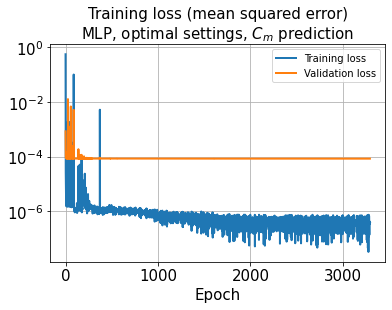

In [31]:
hist = history.history
plt.plot(hist['loss'], lw=2, label='Training loss')
plt.plot(hist['val_loss'], lw=2, label='Validation loss')
plt.title('Training loss (mean squared error)\nMLP, optimal settings, $C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
#plt.ylim([5e-5, 1e-1])
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.legend(loc='upper right')
saveName = "TrainingLoss_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

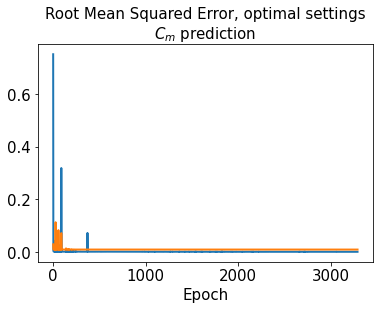

In [32]:
plt.plot(hist['rmse'], lw=2)
plt.plot(hist['val_rmse'], lw=2)
plt.title('Root Mean Squared Error, optimal settings\n$C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

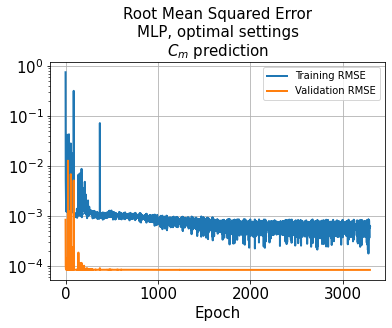

In [33]:
plt.plot(hist['rmse'], lw=2, label='Training RMSE')
plt.plot(hist['val_loss'], lw=2, label='Validation RMSE')
plt.title('Root Mean Squared Error\nMLP, optimal settings\n$C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.legend(loc='upper right')
saveName = "RMSE_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [34]:
train_results = model.evaluate(x_train, y_train)

1750/1750 [==============================] - 4s 3ms/step - loss: 3.8246e-07 - rmse: 6.1843e-04


In [35]:
val_results = model.evaluate(x_val, y_val)

501/501 [==============================] - 1s 2ms/step - loss: 8.3746e-05 - rmse: 0.0092


In [36]:
test_results = model.evaluate(x_test, y_test)

250/250 [==============================] - 1s 2ms/step - loss: 1.5083e-05 - rmse: 0.0039


In [37]:
decoded_train_ = model.predict(x_train)
decoded_val_ = model.predict(x_val)
decoded_test_ = model.predict(x_test)

250/250 [==============================] - 0s 1ms/step


In [38]:
def define_index(cm, y):
    return np.unique(np.where(np.isin(cm, y)))

In [39]:
def error_absolute(y_pred, y_true):
    return np.abs(y_pred - y_true)

In [40]:
# Denormalize 
def denormalize(y):
    return y*(np.max(cm)-np.min(cm))+np.min(cm)

In [41]:
index_train = define_index(y, y_train)
index_val = define_index(y, y_val)
index_test = define_index(y, y_test)

In [42]:
y_train = denormalize(y_train)
y_val = denormalize(y_val)
y_test = denormalize(y_test)

In [43]:
decoded_train = denormalize(decoded_train_)
decoded_val = denormalize(decoded_val_)
decoded_test = denormalize(decoded_test_)

In [44]:
model_directory = "D:\\TrainedModels\\20221216"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)
os.chdir(model_directory)
model_name = "20221216unsteadyValidation_MLP_val_"+str(val_rate)+"_test"+str(test_rate)+ "_" + str(n_layers) +"layers_"+str(n_units)+"unitsCmPrediction.h5"
model.save(model_name, overwrite=True, include_optimizer=True, save_format='h5')

In [45]:
error_train_abs = error_absolute(decoded_train, y_train)
error_val_abs = error_absolute(decoded_val, y_val)
error_test_abs = error_absolute(decoded_test, y_test)

In [46]:
os.chdir(storage_dir)

In [47]:
def l2_error(y_pred, y_real):
    return np.sqrt(np.sum((y_pred - y_real)**2) / np.sum(y_real**2))

def mape(y_pred, y_real):
    return 100/len(y_real)*np.sum(np.abs((y_real-y_pred)/y_real))

def smape(y_pred, y_real):
    return 100*np.sum(np.abs(y_pred-y_real))/np.sum(y_real+y_pred)

In [48]:
l2_error_train = l2_error(decoded_train, y_train)
mape_train = mape(decoded_train, y_train)
print(l2_error_train)
print(mape_train)

0.49968730817872886
143.82740562020143


In [49]:
l2_error_val = l2_error(decoded_val, y_val)
mape_val= mape(decoded_val, y_val)
print(l2_error_val)
print(mape_val)

0.9925664183611695
150.32478015672407


In [50]:
l2_error_test = l2_error(decoded_test, y_test)
mape_test= mape(decoded_test, y_test)
print(l2_error_test)
print(mape_test)

0.9553186702663301
231.41420656538844


In [51]:
l2_error_train_list = []
for i in range(0, len(x_train)):
    l2_error_train_data = l2_error(decoded_train[i], y_train[i])
    l2_error_train_list.append(l2_error_train_data)

In [52]:
l2_error_val_list = []
for i in range(0, len(x_val)):
    l2_error_val_data = l2_error(decoded_val[i], y_val[i])
    l2_error_val_list.append(l2_error_val_data)

In [53]:
l2_error_test_list = []
for i in range(0, len(x_test)):
    l2_error_test_data = l2_error(decoded_test[i], y_test[i])
    l2_error_test_list.append(l2_error_test_data)

In [54]:
mape_train_list = []
for i in range(0, len(x_train)):
    mape_train_data = mape(decoded_train[i], y_train[i])
    mape_train_list.append(mape_train_data)

In [55]:
mape_val_list = []
for i in range(0, len(x_val)):
    mape_val_data = mape(decoded_val[i], y_val[i])
    mape_val_list.append(mape_val_data)

In [56]:
mape_test_list = []
for i in range(0, len(x_test)):
    mape_test_data = mape(decoded_test[i], y_test[i])
    mape_test_list.append(mape_test_data)

In [57]:
def distribution_plot(y_pred, y_real, dataset="train"):
    dictionary_name = {"train":"training", "val":"validation", "test":"test"}
    dictionary_data = {"train":l2_error_train_list, "val":l2_error_val_list, "test":l2_error_test_list}
    plot_title = '$L_2$ error norm distribution - MLP, unsteady, '+ dictionary_name.get(dataset) +'.\nValidation rate {0}, test rate {1}, {2} layers, {3} units ($C_m$)'.format(
        val_rate, test_rate, n_layers, n_units)
    plt.plot(np.linspace(1,y_real.shape[0],y_real.shape[0]),
         l2_error_train*np.ones(y_real.shape[0],), 'k', lw=2.5)
    plt.scatter(np.linspace(1, y_real.shape[0], y_real.shape[0]), dictionary_data.get(dataset), c='b')
    plt.xlabel('Index', fontsize=15)
    plt.ylabel('$L_2$ error norm', fontsize=15)
    plt.yscale('log')
    plt.title(plot_title, fontsize=15)
    plt.grid()

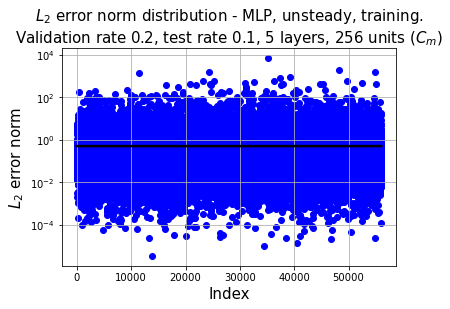

In [58]:
distribution_plot(decoded_train, y_train, dataset="train")
saveName = "trainingErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

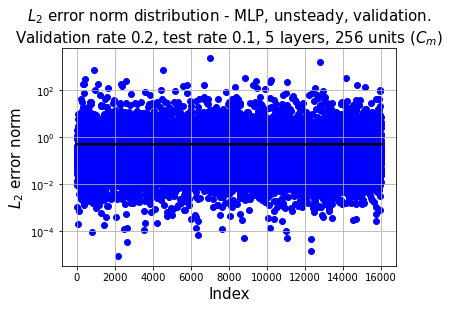

In [59]:
distribution_plot(decoded_val, y_val, dataset="val")
saveName = "validationErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

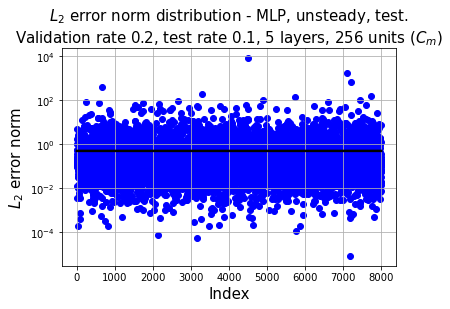

In [60]:
distribution_plot(decoded_test, y_test, dataset="test")
saveName = "testErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [61]:
predicted = model.predict(x)

2500/2500 [==============================] - 4s 1ms/step


In [62]:
np.max(x)

14.99899999999723

In [63]:
t_train = t[index_train]
t_val = t[index_val]
t_test = t[index_test]

In [64]:
iTrain=[]
iVal=[]
iTest=[]
for i, index in enumerate(index_train):
    iTrain.append(y[index])
for k , index in enumerate(index_val):
    iVal.append(y[index])
for j, index in enumerate(index_test):
    iTest.append(y[index])

In [65]:
iTrain = np.array(iTrain)
iVal = np.array(iVal)
iTest = np.array(iTest)

In [69]:
def Cm_trainTestSplit_Plot(i, Cm, cm, tTrain, tTest, iTrain, iTest):
    
    title_0_Cm = 'Gurney flap not attached (NACA0018)\n$C_m$ prediction, $L_2$ error=%.4f' % l2_error_Cm    
    title_n_Cm = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_m$ prediction, $L_2$ error=%.4f'%(l2_error_Cm)
    
    if i==0:
        title_Cm = title_0_Cm
        savename1 = "CmComparison_NACA0018.jpg"
    else:
        title_Cm = title_n_Cm
        savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    
    # CD graph plot
    plt.plot(t[:5000], Cm, 'k-', label='Ground truth')
    plt.plot(t[:5000], cm, 'k--', label='Predicted value')
    plt.scatter(tTrain, iTrain, color='b', label='Training set')
    plt.scatter(tVal, iVal, color='g', label='Validation set')
    plt.scatter(tTest, iTest, color='r', label='Test set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper left')
    plt.ylim([0, 0.0042])
    plt.grid()
    plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

NACA0018 airfoil without Gurney flap
L2 error of Cm: 0.0923


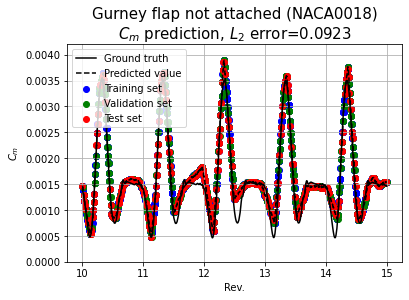

L2 error of Cm: 0.0894


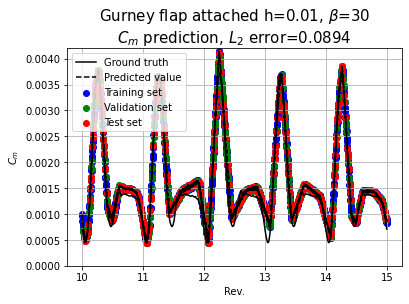

L2 error of Cm: 0.0828


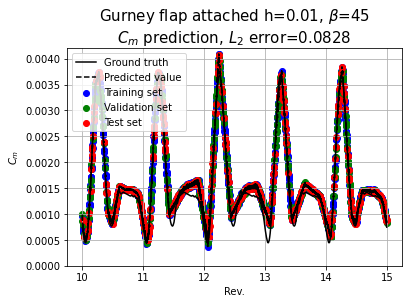

L2 error of Cm: 0.0816


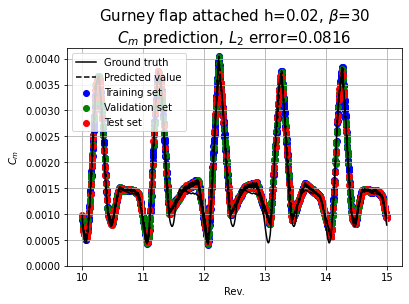

L2 error of Cm: 0.0799


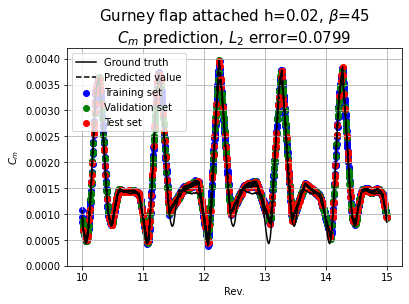

L2 error of Cm: 0.0866


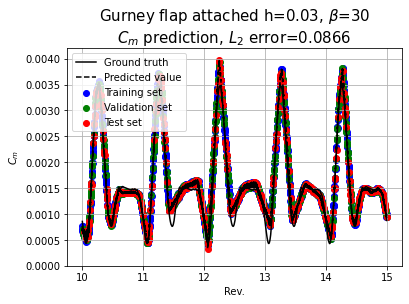

L2 error of Cm: 0.1306


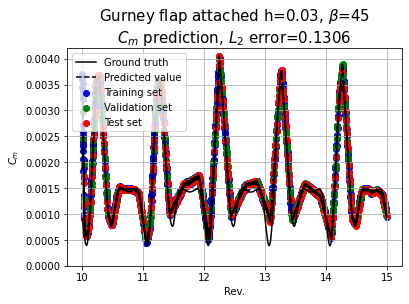

L2 error of Cm: 0.9913


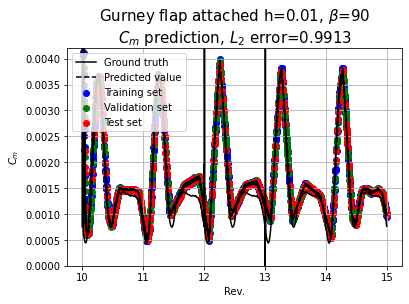

L2 error of Cm: 0.1109


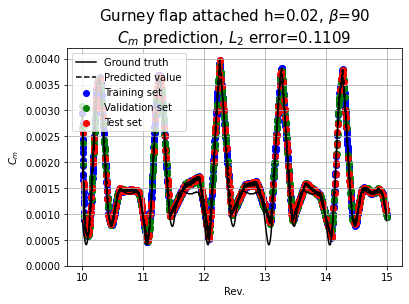

L2 error of Cm: 0.1104


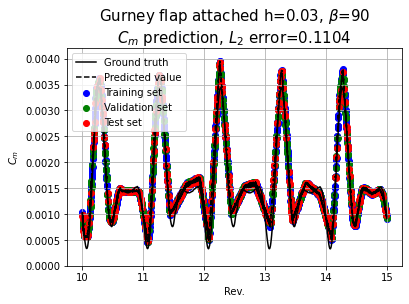

L2 error of Cm: 0.1080


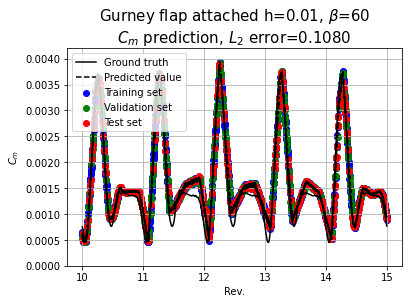

L2 error of Cm: 0.0854


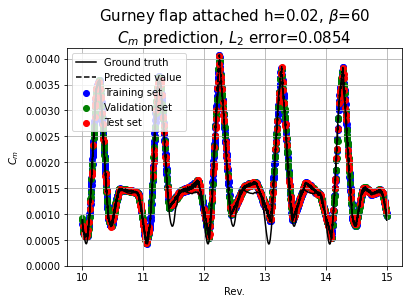

L2 error of Cm: 0.0986


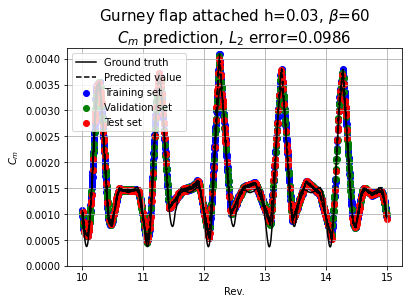

L2 error of Cm: 0.1005


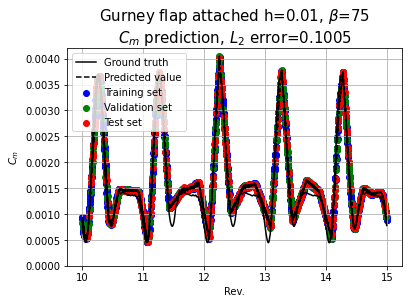

L2 error of Cm: 0.0822


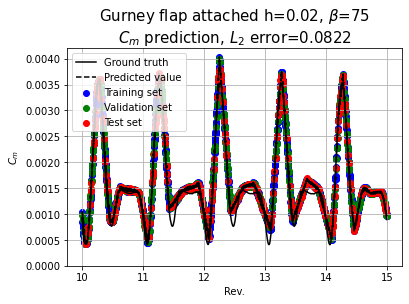

L2 error of Cm: 0.0955


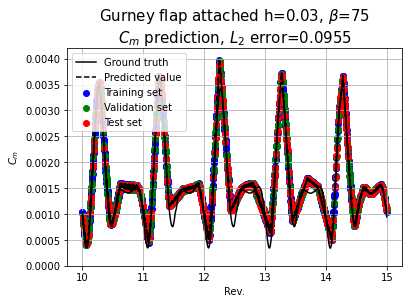

In [71]:
h = [0, 0.01, 0.01, 0.02, 0.02, 0.03, 0.03, 0.01, 0.02, 0.03, 0.01, 0.02, 0.03, 0.01, 0.02, 0.03]
beta = [0, 30, 45, 30, 45, 30, 45, 90, 90, 90, 60, 60, 60, 75, 75, 75]
for i in range(0, 16):
    # Index from each dataset
    iTrain = []
    iVal = []
    iTest = []
    
    # Index from input data (alpha, in this case)
    t_train = []
    t_val = []
    t_test = []
    
    predictedValue = predicted[t_len*i:t_len*(i+1),:]
    y_corres = y[t_len*i:t_len*(i+1),:]
    
    l2_error_Cm = np.sqrt(np.sum((predictedValue - y_corres)**2) / np.sum(y_corres**2))
    
    if i==0:
        print('NACA0018 airfoil without Gurney flap\nL2 error of Cm: {0:0.4f}'.format(l2_error_Cm))
    else:
        print('L2 error of Cm: {0:0.4f}'.format(l2_error_Cm))
    
    cm = predictedValue#denormalize(predictedValue)
    Cm = y_corres#denormalize(y_corres)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        iTrain.append(predicted[index])
    for jj, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        iVal.append(predicted[index])    
    for kk, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & (index_test>=i*t_len))]):
        iTest.append(predicted[index])
        
#     iTrain = denormalize(np.array(iTrain))
#     iTest = denormalize(np.array(iTest))
#     iVal = denormalize(np.array(iVal))
    iTrain = np.array(iTrain)
    iVal = np.array(iVal)
    iTest = np.array(iTest)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        t_train.append(t[index])
    for kk, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        t_val.append(t[index])
    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & ((index_test>=i*t_len)))]):
        t_test.append(t[index])
        
    tTrain = np.array(t_train)
    tVal = np.array(t_val)
    tTest = np.array(t_test)
    
    Cm_trainTestSplit_Plot(i, Cm, cm, tTrain, tTest, iTrain, iTest)

In [73]:
y

array([[0.00140654],
       [0.00140014],
       [0.00139301],
       ...,
       [0.00098973],
       [0.00097144],
       [0.00094349]])

In [72]:
cm

array([[0.00102902],
       [0.00103786],
       [0.00104364],
       ...,
       [0.00105829],
       [0.00107281],
       [0.00103619]], dtype=float32)